# Machine Learning Project

In [1]:
import os, random, warnings, json, time, ast, itertools
from pathlib import Path
from collections import defaultdict

import joblib
import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import ipywidgets as w
from ipywidgets import interact, fixed

import networkx as nx
import statsmodels.api as sm
from scipy.stats import rankdata, pointbiserialr
from tqdm.auto import tqdm

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from collections import defaultdict

import sklearn, warnings
from packaging import version
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from BorutaShap import BorutaShap


In [2]:
N_CPU = os.cpu_count()

## Data Preparation

The datasets are imported and the centrality functions to use are instantiated.

In [3]:
train_raw = pd.read_csv("datasets/train.csv")
test_raw  = pd.read_csv("datasets/test.csv")

In [4]:
CENT_CORE = {
    "pagerank"    : nx.pagerank,
    "eigenvector" : lambda G: nx.eigenvector_centrality_numpy(G),
    "voterank"    : lambda G: {n: r/len(G) for r, n in
                               enumerate(nx.voterank(G)[::-1], 1)},
}

CENT_EXTRA = {
    "degree"      : nx.degree_centrality,
    "closeness"   : nx.closeness_centrality,
    "harmonic"    : nx.harmonic_centrality,
    "katz"        : lambda G: nx.katz_centrality_numpy(G, alpha=0.01),
    "betweenness": nx.betweenness_centrality,
    "load"       : nx.load_centrality,
}

CENT_ALL = CENT_CORE | CENT_EXTRA
LOW_BETTER = {"eccentricity", "farness", "depth_leaf"}#lower rank is better


A function is created to expand and restructure the dataset, transforming the sentence graph into separate rows for each node, so that the problem can be tackled as a classification problem.

In [5]:
def build_nodes(df, keep_extra=True):
    rows = []
    for _, row in df.iterrows():
        G = nx.from_edgelist(ast.literal_eval(row.edgelist))
        n_tok = len(G)

        cents = {**{k: f(G) for k, f in CENT_CORE.items()},
                 **({k: f(G) for k, f in CENT_EXTRA.items()} if keep_extra else {})}

        #structural extras
        ecc   = nx.eccentricity(G)
        clos  = cents.get("closeness", nx.closeness_centrality(G))
        farness = {n: (1/ c if c else 0) for n, c in clos.items()}

        leaves = [v for v in G if G.degree(v) == 1]
        sp     = dict(nx.all_pairs_shortest_path_length(G))
        depth_leaf = {v: max(sp[v][l] for l in leaves) for v in G}

        #branchiness = leaves within 2 hops
        branch2 = {}
        for v in G:
            branch2[v] = sum(1 for nbr,d in sp[v].items()
                               if d <= 2 and G.degree(nbr) == 1 and nbr != v)

        for n in G:
            feat = {
                "language" : row.language,
                "sentence" : row.sentence,
                "node"     : n,
                "n_tokens" : n_tok,
                **{k: v.get(n, 0.) for k, v in cents.items()},
                "eccentricity": ecc[n],
                "farness"     : farness[n],
                "depth_leaf"  : depth_leaf[n],
                "branch2"     : branch2[n],
            }
            if "root" in row:
                feat["target"] = int(n == row.root)
            rows.append(feat)

    df = pd.DataFrame(rows)

    #scale raw centralities sentence-wise
    raw_cols = list(CENT_CORE) + (list(CENT_EXTRA) if keep_extra else [])
    df[raw_cols] = df.groupby("sentence")[raw_cols] \
                     .transform(lambda x: MinMaxScaler().fit_transform(
                                   x.values.reshape(-1,1)).ravel())

    #position
    df["pos_idx"]  = df["node"].astype(int) - 1
    df["pos_frac"] = df["pos_idx"] / (df["n_tokens"] - 1)
    df["rev_idx"]  = df["n_tokens"] - df["pos_idx"] - 1

    #ranks + percentiles
    rank_cols = raw_cols + ["eccentricity","farness","branch2","depth_leaf"]
    for c in rank_cols:
        rk = df.groupby("sentence")[c] \
               .transform(lambda x: rankdata(
                   x if c in LOW_BETTER else -x, method="average"))
        df[f"{c}_rank"] = rk
        df[f"{c}_pct"]  = rk / (df["n_tokens"] - 1)

    core_pct = [f"{c}_pct" for c in ["pagerank","eigenvector","voterank"]]
    df["meta_rank"] = df[core_pct].mean(axis=1)
    df["meta_rank_resid"] = df["meta_rank"] - \
                            df.groupby("language")["meta_rank"].transform("mean")
    return df

Buckets are created to split the sentences based on their length.

In [36]:
train_nodes = build_nodes(train_raw, keep_extra=True)
test_nodes  = build_nodes(test_raw , keep_extra=True)

## Exploratory Data Analysis

In [7]:
#stats
summary = (
    train_nodes
      .drop_duplicates(["language", "sentence"])
      .groupby("language")["n_tokens"]
      .agg(["count", "mean", "median", "min", "max", "std"])
      .sort_values("mean", ascending=False)
)
print(summary.head(21))

            count    mean  median  min  max       std
language                                             
Japanese      500  25.812    25.0    6   70  9.707168
French        500  22.380    21.0    4   54  8.915749
Thai          500  22.124    21.0    4   63  8.622373
Hindi         500  21.826    21.0    4   52  8.611855
Italian       500  21.680    20.5    3   59  9.039747
Galician      500  21.234    20.0    3   55  8.783025
Spanish       500  21.194    20.0    3   58  8.574579
Portuguese    500  20.968    20.0    4   57  8.424543
English       500  18.830    18.0    4   48  7.230883
German        500  18.764    18.0    4   47  7.392266
Chinese       500  18.584    18.0    3   49  7.325727
Arabic        500  18.486    18.0    3   50  7.685567
Swedish       500  17.252    17.0    4   49  6.928818
Indonesian    500  17.150    17.0    3   44  6.837031
Icelandic     500  16.754    16.0    4   52  6.939871
Russian       500  16.448    16.0    3   43  6.660632
Czech         500  16.110   

In [8]:
summary = (
    test_nodes
      .drop_duplicates(["language", "sentence"])
      .groupby("language")["n_tokens"]
      .agg(["count", "mean", "median", "min", "max", "std"])
      .sort_values("mean", ascending=False)
)
print(summary.head(21))

            count       mean  median  min  max        std
language                                                 
Japanese      495  25.854545    25.0    4   67  10.104868
Thai          495  22.155556    21.0    5   55   8.893775
French        495  22.145455    21.0    5   52   9.089025
Hindi         495  21.412121    21.0    4   58   8.842748
Italian       495  21.349495    21.0    4   60   8.985879
Galician      495  21.056566    20.0    4   67   8.964439
Spanish       495  20.973737    20.0    4   58   8.619329
Portuguese    495  20.894949    20.0    4   58   8.651664
English       495  18.777778    18.0    4   56   7.396185
Arabic        495  18.715152    18.0    3   49   7.994031
Chinese       495  18.593939    18.0    4   46   7.576517
German        495  18.505051    18.0    4   50   7.356142
Swedish       495  17.147475    16.0    4   47   6.972798
Icelandic     495  17.127273    16.0    3   48   7.022950
Indonesian    495  17.115152    16.0    3   45   6.739279
Russian       

### Analyzing Sentence Length

### Histogram view

Given the wide spread in sentence length between languages buckets were used as a way to provide

In [37]:
BUCKET_EDGES  = [-1,5,10,15,20,25,30,40,1e9]
BUCKET_LABELS = range(len(BUCKET_EDGES)-1)
for df in (train_nodes, test_nodes):
    df["bucket"] = pd.cut(df["n_tokens"], BUCKET_EDGES, labels=BUCKET_LABELS)
    df[["language","bucket"]] = df[["language","bucket"]].astype("category")

In [10]:
#sentence-length distribution
sent_train = (
    train_nodes
      .drop_duplicates(['language', 'sentence'])
      .loc[:, ['language', 'n_tokens']]
)

sent_test  = (
    test_nodes
      .drop_duplicates(['language', 'sentence'])
      .loc[:, ['language', 'n_tokens']]
)

def make_bins(data, mode='unit'):
    if mode == 'unit':
        lo, hi = data.min(), data.max()
        return range(lo, hi + 2) 
    else:
        edges = list(range(1, 71, 5))
        return edges

def plot_len_hist(language, dataset='train', binning='unit'):
    df = sent_train if dataset == 'train' else sent_test
    lengths = df.loc[df.language == language, 'n_tokens']
    bins = make_bins(lengths, binning)

    q05, q95 = lengths.quantile([0.05, 0.95]).values

    plt.figure(figsize=(6, 4))
    plt.hist(lengths, bins=bins)

    plt.axvline(q05, linestyle='--', label='q05')
    plt.axvline(q95, linestyle='--', label='q95')

    plt.xlabel('sentence length (tokens)')
    plt.ylabel('number of sentences')
    plt.title(f'Sentence-length distribution – {language} ({dataset})')
    plt.legend()
    plt.tight_layout()
    plt.show()

langs = sorted(sent_train.language.unique())
interact(
    plot_len_hist,
    language = langs,
    dataset  = ['train', 'test'],
    binning  = {'exact (bin = 1)': 'unit', 'bucketised': 'bucket'}
)

interactive(children=(Dropdown(description='language', options=('Arabic', 'Chinese', 'Czech', 'English', 'Finn…

<function __main__.plot_len_hist(language, dataset='train', binning='unit')>

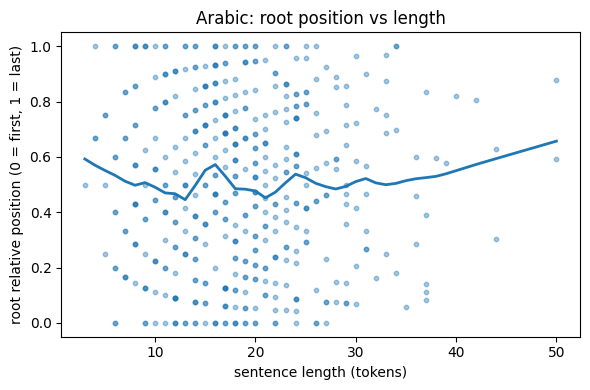

              mean  count
n_tokens                 
≤5        0.635417      8
5–10      0.493578     65
11–15     0.485755    108
16–20     0.511393    146
21–25     0.506333     96
26–30     0.467092     43
31–40     0.520580     29
41+       0.640900      5


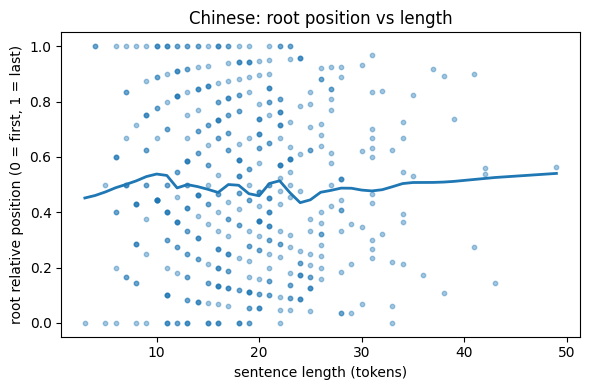

              mean  count
n_tokens                 
≤5        0.500000      5
5–10      0.547307     56
11–15     0.488387    116
16–20     0.476542    140
21–25     0.477012    105
26–30     0.502442     42
31–40     0.508484     30
41+       0.496320      6


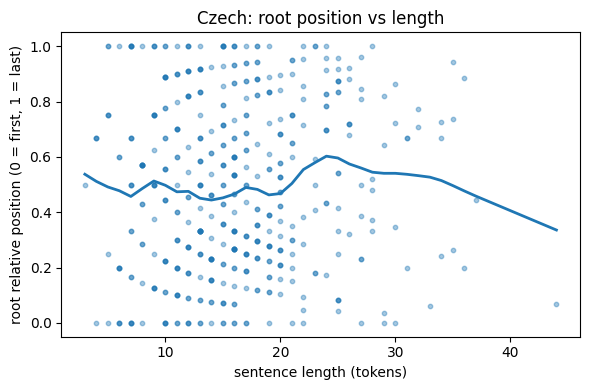

              mean  count
n_tokens                 
≤5        0.583333     12
5–10      0.483324     89
11–15     0.468675    148
16–20     0.477742    145
21–25     0.568799     62
26–30     0.537724     28
31–40     0.545827     15
41+       0.069767      1


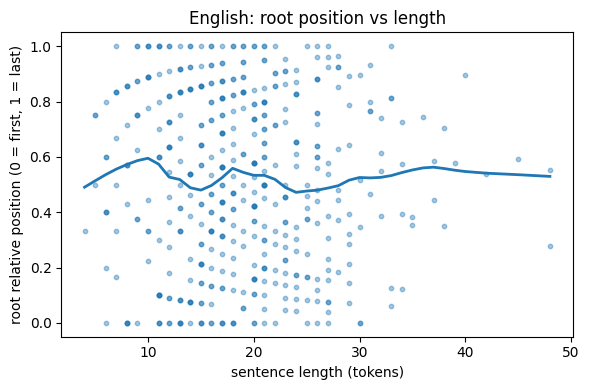

              mean  count
n_tokens                 
≤5        0.583333      4
5–10      0.588959     51
11–15     0.487800    114
16–20     0.523185    145
21–25     0.497824     98
26–30     0.495929     57
31–40     0.581137     27
41+       0.489320      4


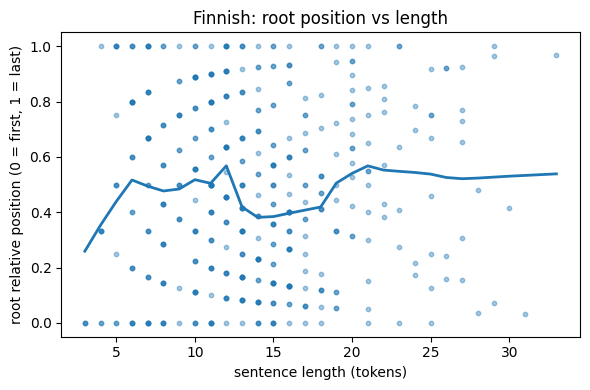

              mean  count
n_tokens                 
≤5        0.420635     21
5–10      0.497152    124
11–15     0.459694    198
16–20     0.460102    103
21–25     0.518443     36
26–30     0.546655     16
31–40     0.501042      2
41+            NaN      0


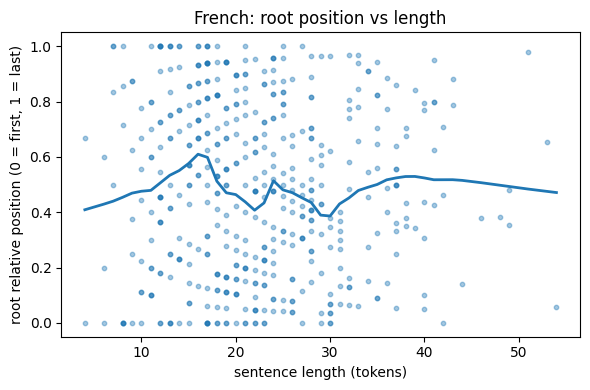

              mean  count
n_tokens                 
≤5        0.333333      2
5–10      0.449773     28
11–15     0.516408     82
16–20     0.534490    123
21–25     0.472690    105
26–30     0.407374     74
31–40     0.490896     68
41+       0.547860     18


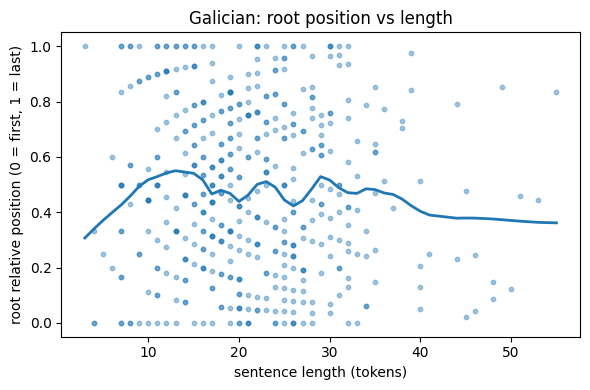

              mean  count
n_tokens                 
≤5        0.316667      5
5–10      0.483617     42
11–15     0.553936     86
16–20     0.462269    123
21–25     0.502415     98
26–30     0.470196     80
31–40     0.470341     52
41+       0.357746     14


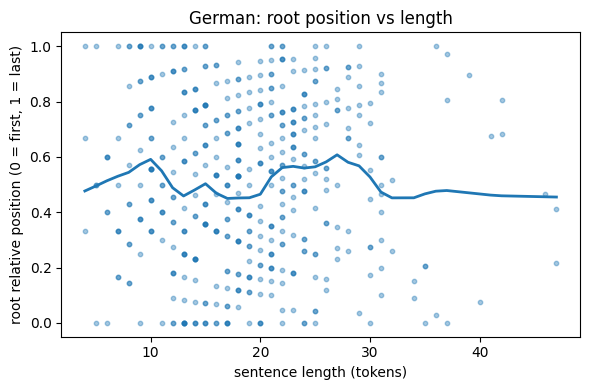

              mean  count
n_tokens                 
≤5        0.571429      7
5–10      0.571572     61
11–15     0.489974    112
16–20     0.451393    123
21–25     0.551878    120
26–30     0.587285     46
31–40     0.438922     25
41+       0.543318      6


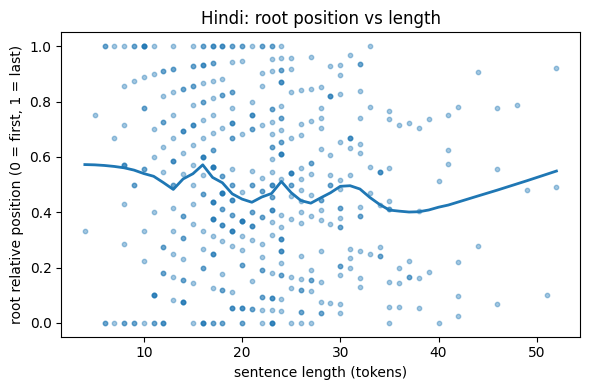

              mean  count
n_tokens                 
≤5        0.541667      2
5–10      0.585210     37
11–15     0.487491     75
16–20     0.498581    128
21–25     0.488670    114
26–30     0.437668     69
31–40     0.445609     58
41+       0.496245     17


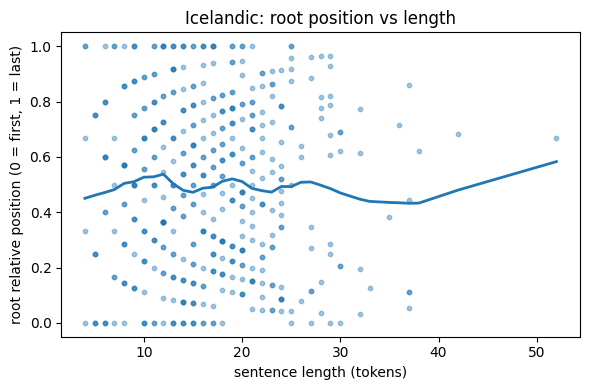

              mean  count
n_tokens                 
≤5        0.428571     14
5–10      0.499544     81
11–15     0.504088    137
16–20     0.507751    137
21–25     0.492148     85
26–30     0.491258     31
31–40     0.387654     13
41+       0.674797      2


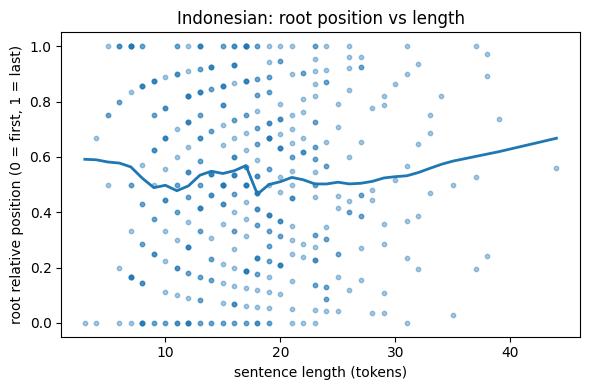

              mean  count
n_tokens                 
≤5        0.523810      7
5–10      0.512850     76
11–15     0.516137    128
16–20     0.518283    156
21–25     0.492886     78
26–30     0.540962     31
31–40     0.567347     23
41+       0.558140      1


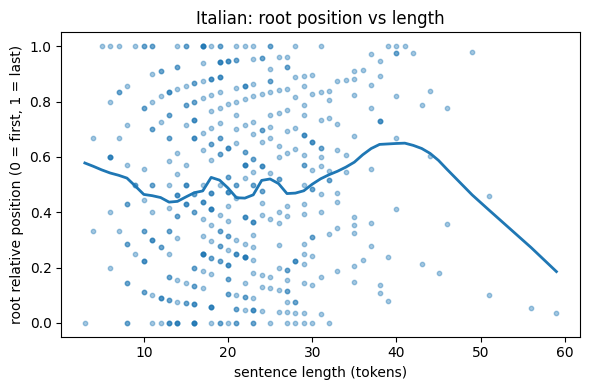

              mean  count
n_tokens                 
≤5        0.500000      4
5–10      0.504510     41
11–15     0.464820     78
16–20     0.490363    127
21–25     0.490258    100
26–30     0.460544     74
31–40     0.582743     62
41+       0.525773     14


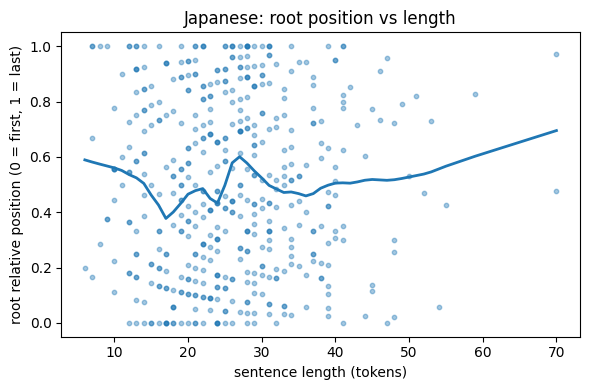

              mean  count
n_tokens                 
≤5             NaN      0
5–10      0.547046     18
11–15     0.533254     53
16–20     0.427283     78
21–25     0.464926    112
26–30     0.570264    104
31–40     0.468752    101
41+       0.555748     34


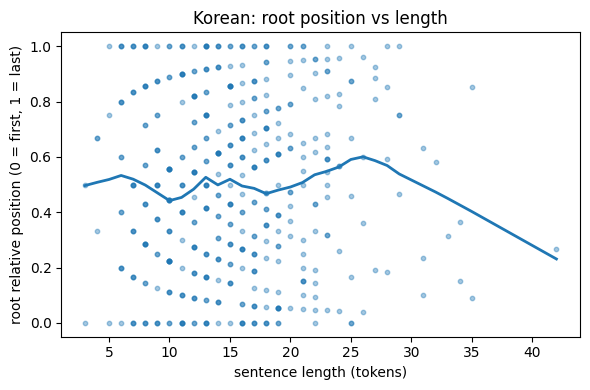

              mean  count
n_tokens                 
≤5        0.489583      8
5–10      0.481566    110
11–15     0.508763    162
16–20     0.484204    133
21–25     0.523389     61
26–30     0.647600     16
31–40     0.368460      9
41+       0.268293      1


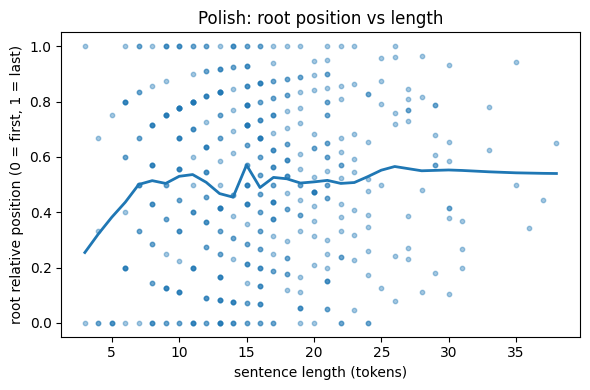

              mean  count
n_tokens                 
≤5        0.275000     10
5–10      0.514983     95
11–15     0.507930    156
16–20     0.509952    131
21–25     0.509063     66
26–30     0.581231     32
31–40     0.511671     10
41+            NaN      0


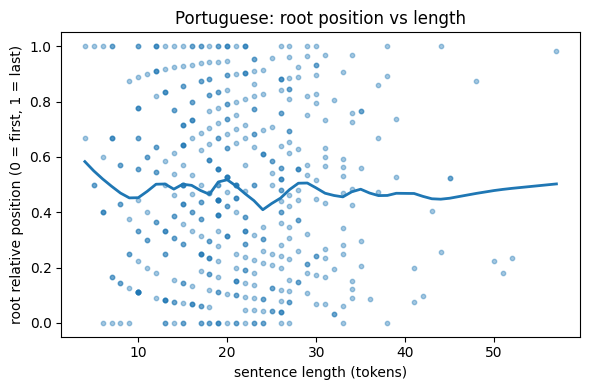

              mean  count
n_tokens                 
≤5        0.733333      5
5–10      0.438996     48
11–15     0.497703     82
16–20     0.510371    126
21–25     0.442350     96
26–30     0.502300     84
31–40     0.462771     46
41+       0.428681     13


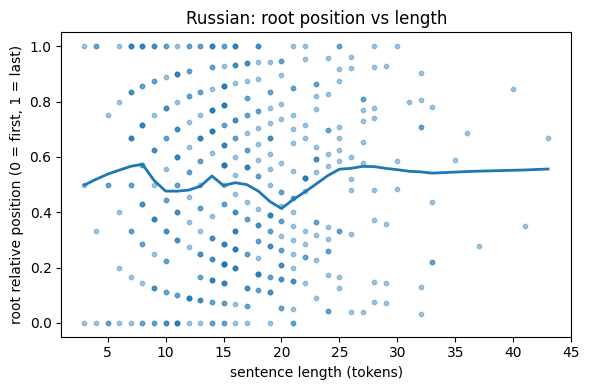

              mean  count
n_tokens                 
≤5        0.465278     12
5–10      0.539530     83
11–15     0.493873    151
16–20     0.477897    134
21–25     0.495527     74
26–30     0.562486     29
31–40     0.542964     15
41+       0.508333      2


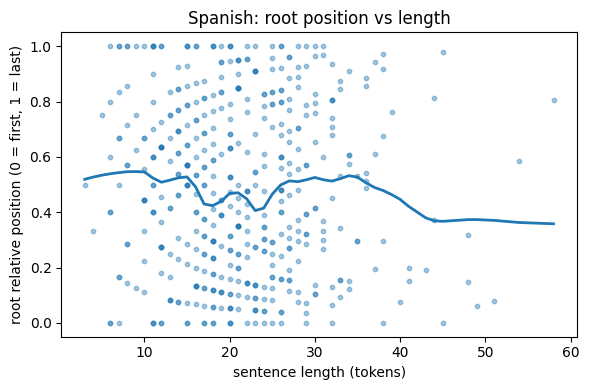

              mean  count
n_tokens                 
≤5        0.527778      3
5–10      0.536548     40
11–15     0.532842     89
16–20     0.445074    122
21–25     0.456106    100
26–30     0.517435     84
31–40     0.526334     49
41+       0.362023     13


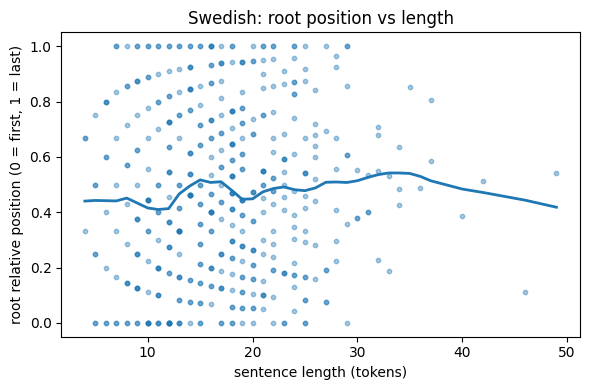

              mean  count
n_tokens                 
≤5        0.391667     10
5–10      0.450881     73
11–15     0.456584    129
16–20     0.484369    145
21–25     0.490557     91
26–30     0.527710     32
31–40     0.521823     17
41+       0.388324      3


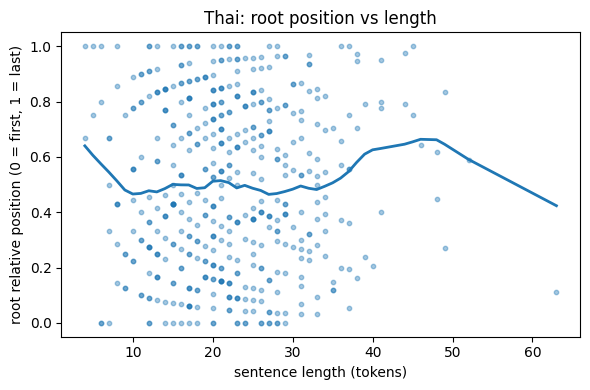

              mean  count
n_tokens                 
≤5        0.854167      4
5–10      0.463594     31
11–15     0.477297     78
16–20     0.502539    113
21–25     0.507683    115
26–30     0.476564     79
31–40     0.488416     65
41+       0.663735     15


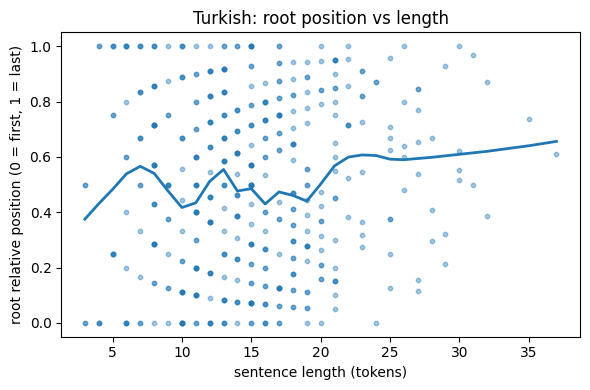

              mean  count
n_tokens                 
≤5        0.472222     18
5–10      0.508296     96
11–15     0.488898    180
16–20     0.460013    129
21–25     0.594111     49
26–30     0.589427     22
31–40     0.678523      6
41+            NaN      0


In [9]:
# Length-based behaviour recognition:

langs = sorted(train_nodes.language.unique())
for LANG in langs:
    roots = (
        train_nodes.query("language == @LANG and target==1")
                   .drop_duplicates("sentence")
    )

    x = roots["n_tokens"].values
    y = roots["pos_frac"].values

    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(x, y, s=10, alpha=0.4)

    # LOWESS smoothing (fraction controls window)
    lowess = sm.nonparametric.lowess(y, x, frac=0.2)
    ax.plot(lowess[:,0], lowess[:,1], linewidth=2)

    ax.set_xlabel("sentence length (tokens)")
    ax.set_ylabel("root relative position (0 = first, 1 = last)")
    ax.set_title(f"{LANG}: root position vs length")
    plt.tight_layout()
    plt.show()

    bins = pd.cut(roots["n_tokens"],
              bins=[-1, 5, 10, 15, 20, 25, 30, 40, 1e9],
              labels=["≤5","5–10","11–15","16–20","21–25","26–30","31–40","41+"])
    bucket_stats = roots.groupby(bins)["pos_frac"].agg(["mean", "count"])
    print(bucket_stats)

### Analyzing relationship between language vs root node

In [11]:
#language vs root (absolute and relative)

root_nodes = train_nodes.loc[train_nodes["target"] == 1, ["language", "sentence", "node", "n_tokens"]].copy()

root_nodes["rel"] = root_nodes["node"] / root_nodes["n_tokens"]
lang_order = train_nodes["language"].drop_duplicates().tolist()

def plot_sentence(sent_id: int, view: str = "absolute"):
    df = (root_nodes[root_nodes["sentence"] == sent_id]
            .set_index("language")
            .loc[lang_order]
            .reset_index())

    fig = go.Figure()

    if view == "absolute":
        #bars for sentence length
        fig.add_bar(
            x=df["language"], y=df["n_tokens"],
            name="#tokens",
            marker_color="cornflowerblue",
            text=df["n_tokens"], textposition="outside"
        )
        #dots for root node id
        fig.add_scatter(
            x=df["language"], y=df["node"],
            mode="markers",
            name="root",
            marker=dict(size=11, color="crimson")
        )
        y_title = "value"
    else:  #relative
        #dots at node/length
        fig.add_scatter(
            x=df["language"], y=df["rel"],
            mode="markers",
            name="root / length",
            marker=dict(size=11, color="crimson")
        )
        fig.update_yaxes(range=[0, 1])
        y_title = "relative root position (0–1)"

    fig.update_layout(
        title=f"Sentence {sent_id}: {'absolute' if view=='absolute' else 'relative'} view",
        yaxis_title=y_title,
        xaxis=dict(categoryorder="array", categoryarray=lang_order),
        bargap=0.28 if view == "absolute" else 0.4,
        width=980, height=480,
        legend=dict(yanchor="top", y=0.97, xanchor="left", x=0.01)
    )

    fig.show()

sent_ids = sorted(root_nodes["sentence"].unique())

sent_slider = w.SelectionSlider(
    options=sent_ids, value=sent_ids[0],
    description="sentence:", continuous_update=False
)

view_dd = w.Dropdown(
    options=[("absolute", "absolute"), ("relative (0–1)", "relative")],
    value="absolute",
    description="view:"
)

ui  = w.VBox([sent_slider, view_dd])
out = w.interactive_output(
        plot_sentence,
        {"sent_id": sent_slider, "view": view_dd}
      )

display(ui, out)


Output()

In [12]:
if "lang_len_prior" not in train_nodes.columns:
    def _add_prior(train_nodes, other_nodes):
        roots = train_nodes.loc[train_nodes.target == 1,
                                ["language", "bucket", "pos_frac"]]
        tbl = roots.groupby(["language", "bucket"])["pos_frac"].mean()

        for df in (train_nodes, other_nodes):
            idx = pd.MultiIndex.from_arrays([df["language"], df["bucket"]])
            pr  = tbl.reindex(idx).to_numpy()
            df["lang_len_prior"]  = pr
            df["dist_from_prior"] = df["pos_frac"] - pr

    _add_prior(train_nodes, test_nodes)

### Analyzing relationship between language and centrality values

The graph shows the average ranking of the root node in terms of centralities for every language. As we can see Japanese is showing terrible rankings compared to the other languages, indicating that the chosen centrality functions may not be the best equipped to handle that particular language.

In [13]:
#centralities
EXTRA_PCT = ["branch2_pct", "depth_leaf_pct"]
CENT_PCT   = [c + "_pct" for c in CENT_ALL] + ["voterank_pct"] + EXTRA_PCT
CENT_PCT = [c+"_pct" for c in CENT_ALL] + ["voterank_pct"]
rank_df = (
    train_nodes
      .melt(id_vars=["language","sentence","node","target"],
            value_vars=CENT_PCT, var_name="cent", value_name="val")
      .assign(rank=lambda d:
              d.groupby(["language","sentence","cent"])["val"]
                .rank("min", ascending=True))   # pct: smaller is better
      .loc[lambda d: d.target==1]
)

disp = (rank_df.groupby(["language","cent"])["rank"]
               .mean().unstack())
disp.style.format("{:.1f}").background_gradient("YlGn_r")


cent,betweenness_pct,closeness_pct,degree_pct,eigenvector_pct,harmonic_pct,katz_pct,load_pct,pagerank_pct,voterank_pct
language,,,,,,,,,
Arabic,3.9,4.7,2.9,5.0,4.3,4.2,3.9,4.6,3.7
Chinese,4.7,4.4,3.4,4.3,4.3,4.6,4.7,5.5,4.6
Czech,3.5,4.3,2.6,4.8,4.0,3.9,3.5,4.2,3.6
English,3.8,4.7,2.6,5.2,4.1,3.8,3.8,4.3,3.9
Finnish,2.9,3.4,2.2,3.8,3.2,3.1,2.9,3.3,2.9
French,4.0,4.8,3.1,5.4,4.3,4.4,4.0,5.4,4.9
Galician,4.1,4.8,3.3,5.3,4.4,4.5,4.1,5.4,4.9
German,3.4,4.0,2.6,4.5,3.6,3.5,3.4,4.2,3.8
Hindi,6.0,6.9,5.0,7.7,6.9,7.1,6.0,8.0,6.2


In [15]:
#filling NaNs
print("NaNs in train:", train_nodes["lang_len_prior"].isna().sum())
print("NaNs in  test:", test_nodes ["lang_len_prior"].isna().sum())
def missing_pairs(df):
    return (
        df.loc[df["lang_len_prior"].isna(), ["language", "bucket"]]
          .value_counts()
          .rename("rows")
          .reset_index()
          .sort_values("rows", ascending=False)
    )

print("\nMissing pairs in TRAIN:")
display(missing_pairs(train_nodes))

print("\nMissing pairs in TEST:")
display(missing_pairs(test_nodes))


NaNs in train: 0
NaNs in  test: 4

Missing pairs in TRAIN:


,language,bucket,rows



Missing pairs in TEST:


,language,bucket,rows
0,Japanese,0,4


In [16]:
prior_tbl = (train_nodes.loc[train_nodes.target == 1]
                           .groupby(["language", "bucket"])["pos_frac"]
                           .mean())
j0 = (test_nodes["language"] == "Japanese") & (test_nodes["bucket"] == 0)

if j0.any():
    jp_prior_b1 = prior_tbl[("Japanese", 1)] #mean pos_frac for bucket 1
    test_nodes.loc[j0, "lang_len_prior"]  = jp_prior_b1
    test_nodes.loc[j0, "dist_from_prior"] = test_nodes.loc[j0, "pos_frac"] - jp_prior_b1

In [17]:
print("\nMissing pairs in TRAIN:")
display(missing_pairs(train_nodes))

print("\nMissing pairs in TEST:")
display(missing_pairs(test_nodes))


Missing pairs in TRAIN:


,language,bucket,rows



Missing pairs in TEST:


,language,bucket,rows


## Feature Selection

We've seen that not every language is correctly served by the selection of centrality functions. It's also important to notice if there's some level of redundancy that occurs when working with such a large collection of input values. The following table shows how much correlation exists between different centrality values to identify any redundancies.

In [ ]:
cols = ['pos_frac','rev_idx','lang_len_prior','dist_from_prior'] + \
       [c for c in train_nodes.columns if c.endswith('_pct')]

spearman = train_nodes[cols].corr("spearman")
plt.figure(figsize=(14,10))
sns.heatmap(spearman.abs(), cmap="viridis")
plt.show()

We can see that there are multiple strongly correlated values, so performing feature selection is necessary before we begin training our model.

### Feature selection with BorutaShap

In [ ]:
FEATURES = [c for c in train_nodes.columns if c not in ["language","sentence","node","target"]]

X_full = train_nodes[FEATURES]
y_full = train_nodes["target"].values
sid    = train_nodes["sentence"].values

boruta = BorutaShap(
    model=LGBMClassifier(
        n_estimators=400, learning_rate=0.03,
        num_leaves=63, max_depth=-1, random_state=0
    ),
    importance_measure="shap",
    classification=True
)
N_ROWS = X_full.shape[0]
boruta.fit(
    X=X_full, y=y_full,
    sample_weight=1.0 / train_nodes["n_tokens"],
    n_trials=100,
    sample=False,
    stratify=y_full,
    verbose=False
)

FEATURES = boruta.Subset().columns.tolist()
print("Boruta kept", len(FEATURES), "features:")
print(FEATURES)


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7350, number of negative: 130885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21242
[LightGBM] [Info] Number of data points in the train set: 138235, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065931 -> initscore=-2.650940
[LightGBM] [Info] Start training from score -2.650940
[LightGBM] [Info] Number of positive: 7350, number of negative: 130885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21242
[LightGBM] [Info] Number of data points in the train set: 138235, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065931 -> initscore=-2.65094

In [27]:
#dedublicated features from previous Boruta clean-up
FEATURES = ['pagerank_pct', 'branch2_pct',
            'degree_pct', 'betweenness_pct', 'closeness',
            'meta_rank_resid', 'eigenvector', 'farness',
            'voterank_pct', 'harmonic_rank',
            'lang_len_prior', 'degree', 'branch2_rank',
            'dist_from_prior', 'pos_frac',
            'language', 'bucket']

----

## Modelling

With the data set explored and the correct features selected, we can begin to create models for testing.

In [19]:
def per_language_sentence_accuracy(y, p, sid, lang):
    df = pd.DataFrame({"sid": sid, "lang": lang, "y": y, "p": p})
    idx_top = df.groupby(["lang", "sid"])["p"].idxmax()
    df_top  = df.loc[idx_top]

    return df_top.groupby("lang")["y"].mean()


In [23]:
#logreg

from collections import defaultdict
from sklearn.metrics import roc_auc_score, average_precision_score

def sentence_level_table(y, p, sid, lang):
    df = (pd.DataFrame({"sid": sid, "language": lang,"y": y,  "p": p})
            .loc[lambda d: d.groupby("sid")["p"].idxmax()])
    return df

def update_lang_counters(df_sent, lang_ok, lang_tot):
    correct = (df_sent["y"] == 1).astype(int)
    for g, cnt in correct.groupby(df_sent["language"]):
        lang_ok[g]  += cnt.sum()
        lang_tot[g] += cnt.size

CAT_COLS  = ['language', 'bucket']
NUM_COLS  = [c for c in FEATURES if c not in CAT_COLS]

X_full = train_nodes[FEATURES]
y_full = train_nodes["target"].values
sid    = train_nodes["sentence"].values

ohe_kwargs = dict(handle_unknown="ignore")
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = True
else:
    ohe_kwargs["sparse"] = True

ohe  = OneHotEncoder(**ohe_kwargs)
prep = ColumnTransformer(
        [("cat", ohe, CAT_COLS),
         ("num", "passthrough", NUM_COLS)],
        remainder="drop")

logit = LogisticRegression(
            penalty="l1", solver="liblinear",
            C=0.8, max_iter=300, random_state=0)

pipe = Pipeline([("prep", prep), ("clf", logit)])

import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score
def acc_at1(y, p, sid, lang):
    df = pd.DataFrame({"sid": sid, "lang": lang, "y": y, "p": p})
    top = df.loc[df.groupby(["lang", "sid"])["p"].idxmax(), "y"]
    return (top == 1).mean()

#outer 5-fold SGKF
from sklearn.model_selection import StratifiedGroupKFold
sent_ids = train_nodes.drop_duplicates("sentence")["sentence"].to_numpy()
bucket_by_sid = (train_nodes
                 .groupby("sentence")["bucket"]
                 .agg(lambda s: s.value_counts().idxmax())
                 .astype(str)
                 .reindex(sent_ids))

length_labels = bucket_by_sid.to_numpy()

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
def collapse_by_lang_sentence(y, p, sid, lang):
    """Return df with one row per (language, sentence)."""
    df_nodes = pd.DataFrame({"sid": sid, "lang": lang, "y": y, "p": p})
    idx_best = df_nodes.groupby(["lang", "sid"])["p"].idxmax()
    return df_nodes.loc[idx_best]

def update_lang_totals(df_sent, correct_tot, all_tot):
    """Increment per-language correct / total counters."""
    for g, grp in df_sent.groupby("lang"):
        all_tot[g]     += len(grp)
        correct_tot[g] += grp["y"].sum()

acc_global_cv  = []
lang_correct   = defaultdict(int)
lang_total     = defaultdict(int)
node_pred_all  = []
node_true_all  = []

for tr_pos, va_pos in sgkf.split(np.zeros_like(sent_ids), y=length_labels, groups=sent_ids):

    sent_tr = sent_ids[tr_pos]
    sent_va = sent_ids[va_pos]

    tr_mask = train_nodes["sentence"].isin(sent_tr)
    va_mask = train_nodes["sentence"].isin(sent_va)

    pipe.fit(X_full.loc[tr_mask], y_full[tr_mask],
             clf__sample_weight=1.0 /
                                train_nodes.loc[tr_mask, "n_tokens"])

    y_pred_nodes = pipe.predict_proba(X_full.loc[va_mask])[:, 1]
    y_true_nodes = y_full[va_mask]
    node_pred_all.append(y_pred_nodes)
    node_true_all.append(y_true_nodes)

    df_sent = collapse_by_lang_sentence(y_true_nodes, y_pred_nodes, sid[va_mask], train_nodes.loc[va_mask,"language"])

    acc_global_cv.append(df_sent["y"].mean())
    update_lang_totals(df_sent, lang_correct, lang_total)

print(f"LogReg outer-CV accuracy@1 : "
      f"{np.mean(acc_global_cv):.3f} ± {np.std(acc_global_cv):.3f}")

print("\nPer-language sentence accuracy:")
for g, acc in sorted({g: lang_correct[g]/lang_total[g]
                      for g in lang_total}.items(),
                     key=lambda x: -x[1]):
    print(f"  {g:>10s} : {acc:.3f}   (n={lang_total[g]})")

LogReg outer-CV accuracy@1 : 0.288 ± 0.017

Per-language sentence accuracy:
     Russian : 0.378   (n=500)
     Finnish : 0.370   (n=500)
   Icelandic : 0.362   (n=500)
     Turkish : 0.330   (n=500)
      Arabic : 0.324   (n=500)
      Polish : 0.324   (n=500)
     Swedish : 0.316   (n=500)
      Korean : 0.314   (n=500)
  Portuguese : 0.312   (n=500)
       Czech : 0.306   (n=500)
  Indonesian : 0.298   (n=500)
     Spanish : 0.298   (n=500)
      German : 0.292   (n=500)
     Chinese : 0.286   (n=500)
     English : 0.272   (n=500)
    Galician : 0.268   (n=500)
        Thai : 0.258   (n=500)
      French : 0.256   (n=500)
     Italian : 0.226   (n=500)
       Hindi : 0.210   (n=500)
    Japanese : 0.042   (n=500)


In [28]:
# 5 boosting models + Random Forest
# outer 5-fold StratifiedGroupKFold on (sentence, bucket)
# inner 90 / 10 GroupShuffleSplit + Optuna tuning (no group leakage)
# models: LightGBM, CatBoost, XGBoost, HistGradientBoosting, Random Forest
# accuracy@1 on (language, sentence) + per-language report
# deterministic seeds, Optuna SuccessiveHalving pruner

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)
PRUNER = optuna.pruners.SuccessiveHalvingPruner(min_resource=10)

FEATURES = ["pagerank_pct","branch2_pct","degree_pct",
            "betweenness_pct","closeness","meta_rank_resid","eigenvector",
            "farness","voterank_pct","harmonic_rank","lang_len_prior",
            "degree","branch2_rank","dist_from_prior",
            "pos_frac","n_tokens","language","bucket"]
CAT_COLS  = ["language","bucket"]

X_full    = train_nodes[FEATURES]
y_full    = train_nodes["target"].to_numpy()
sid_full  = train_nodes["sentence"].astype("int64").to_numpy()
lang_full = train_nodes["language"].to_numpy()
w_full    = 1.0 / np.sqrt(train_nodes["n_tokens"].to_numpy())
CAT_IDX   = [X_full.columns.get_loc(c) for c in CAT_COLS]

# numeric frame for models that need it
cat_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_enc = X_full.copy()
X_enc[CAT_COLS] = cat_enc.fit_transform(X_full[CAT_COLS])

In [29]:
import time, sys
class _ConsoleLogger:
    def __init__(self):
        self.best = None
        self.best_id = None
    def __call__(self, study, trial):
        self.best     = study.best_value
        self.best_id  = study.best_trial.number
        msg = (f"[I] {time.strftime('%H:%M:%S')}  Trial {trial.number} "
               f"finished value: {trial.value:.6f}.  "
               f"Best is {self.best_id} ({self.best:.6f})")
        print(msg, file=sys.stderr)


def timeit_step(tag):
    def _wrap(fn):
        def inner(*a, **k):
            t0 = time.time()
            res = fn(*a, **k)
            tqdm.write(f"      ↳ {tag} took {time.time()-t0:5.1f}s")
            return res
        return inner
    return _wrap


In [30]:
def make_group_val_split(X, y, groups, val=0.10, seed=SEED):
    gss = GroupShuffleSplit(n_splits=1, test_size=val, random_state=seed)
    return next(gss.split(X, y, groups))

def acc_at1(y, p, sid, lang):
    df = pd.DataFrame({"sid": sid, "lang": lang, "y": y, "p": p})
    top = df.loc[df.groupby(["lang", "sid"])["p"].idxmax(), "y"]
    return (top == 1).mean()

def lang_acc_series(y, p, sid, lang):
    df = pd.DataFrame({"sid": sid, "lang": lang, "y": y, "p": p})
    idx = df.groupby(["lang", "sid"])["p"].idxmax()
    return df.loc[idx].groupby("lang")["y"].mean()

def _split_inner(X, y, sid, lang, w):
    tr, va = make_group_val_split(X, y, sid)
    return X.iloc[tr], X.iloc[va], y[tr], y[va], sid[tr], sid[va], lang[tr], lang[va], w[tr], w[va]

def _group_lengths_lang_sid(lang, sid):
    """Group lengths for each (lang, sid) in the original row order."""
    key = pd.Series(list(zip(lang, sid)))
    return (key.value_counts(sort=False).loc[key.unique()].to_numpy())


In [31]:
#funcs for optuna
def obj_lgb(trial, X, y, sid, lang, w):
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = _split_inner(X, y, sid, lang, w)
    params = dict(objective="binary", metric="binary_logloss", random_state=SEED,
                  learning_rate=trial.suggest_float("learning_rate",0.01,0.2,log=True),
                  num_leaves=trial.suggest_int("num_leaves",31,255),
                  feature_fraction=trial.suggest_float("feature_fraction",0.6,1.0),
                  bagging_fraction=trial.suggest_float("bagging_fraction",0.6,1.0),
                  bagging_freq=5,
                  num_threads=N_CPU,
                  lambda_l1=trial.suggest_float("lambda_l1",0.0,2.0),
                  lambda_l2=trial.suggest_float("lambda_l2",0.0,2.0),
                  verbose=-1, force_col_wise=True)
    mdl = lgb.LGBMClassifier(**params, n_estimators=3000)
    mdl.fit(Xt, yt, sample_weight=wt, categorical_feature=CAT_IDX,
            eval_set=[(Xv, yv)], eval_sample_weight=[wv],
            callbacks=[lgb.early_stopping(50, verbose=False)])
    trial.set_user_attr("n_round", mdl.best_iteration_ or 3000)
    p = mdl.predict_proba(Xv, num_iteration=mdl.best_iteration_)[:,1]
    return 1 - acc_at1(yv, p, sidv, langv)


def obj_lgb_rank(trial, X, y, sid, lang, w):
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = \
        _split_inner(X, y, sid, lang, w)

    g_tr = _group_lengths_lang_sid(langt, sidt)
    g_va = _group_lengths_lang_sid(langv, sidv)

    params = dict(
        objective        = "lambdarank",
        metric           = "ndcg",
        eval_at          = [1],
        random_state     = SEED,
        learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves       = trial.suggest_int("num_leaves", 31, 255),
        feature_fraction = trial.suggest_float("feature_fraction", 0.6, 1.0),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.6, 1.0),
        bagging_freq     = 5,
        lambda_l1        = trial.suggest_float("lambda_l1", 0.0, 2.0),
        lambda_l2        = trial.suggest_float("lambda_l2", 0.0, 2.0),
        verbose          = -1,
        num_threads      = N_CPU,
    )

    rk = lgb.LGBMRanker(**params, n_estimators=3000)
    rk.fit(Xt, yt,
           group=g_tr,
           eval_set=[(Xv, yv)],
           eval_group=[g_va],
           sample_weight=wt,
           eval_sample_weight=[wv],
           callbacks=[lgb.early_stopping(50, verbose=False)])

    trial.set_user_attr("n_round", rk.best_iteration_ or 3000)

    p_val = rk.predict(Xv, num_iteration=rk.best_iteration_)
    return 1 - acc_at1(yv, p_val, sidv, langv)


def obj_cat(trial, X, y, sid, lang, w):
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = _split_inner(X, y, sid, lang, w)
    train_pool = Pool(data=Xt, label=yt, cat_features=CAT_IDX, weight=wt)
    valid_pool = Pool(data=Xv, label=yv, cat_features=CAT_IDX, weight=wv)

    params = dict(
        loss_function="Logloss",
        random_seed=SEED,
        verbose=False,
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        border_count=trial.suggest_int("border_count", 32, 255),
        thread_count=N_CPU,
    )

    mdl = CatBoostClassifier(**params, iterations=3000)
    mdl.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

    best_iter = mdl.get_best_iteration() or 3000
    trial.set_user_attr("n_round", best_iter)

    p = mdl.predict_proba(valid_pool)[:, 1]
    return 1 - acc_at1(yv, p, sidv, langv)


def obj_xgb(trial, X, y, sid, lang, w):
    import xgboost as xgb
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = _split_inner(X, y, sid, lang, w)
    Xt = Xt.copy();  Xv = Xv.copy()
    for c in CAT_COLS:
        Xt[c] = Xt[c].cat.codes
        Xv[c] = Xv[c].cat.codes
    dtr = xgb.DMatrix(Xt, label=yt, weight=wt)
    dva = xgb.DMatrix(Xv, label=yv, weight=wv)
    params = dict(objective="binary:logistic", seed=SEED,
                  learning_rate=trial.suggest_float("learning_rate",0.01,0.2,log=True),
                  max_depth=trial.suggest_int("max_depth",3,10),
                  min_child_weight=trial.suggest_int("min_child_weight",1,10),
                  subsample=trial.suggest_float("subsample",0.6,1.0),
                  colsample_bytree=trial.suggest_float("colsample_bytree",0.6,1.0),
                  reg_lambda=trial.suggest_float("reg_lambda",0.0,5.0),
                  alpha=trial.suggest_float("alpha",0.0,5.0),
                  nthread=N_CPU,
                  tree_method="hist", eval_metric="logloss")
    booster = xgb.train(params, dtr, 4000,
                        evals=[(dva,"val")], early_stopping_rounds=50,
                        verbose_eval=False)
    trial.set_user_attr("n_round", booster.best_iteration or 3000)
    p = booster.predict(dva, iteration_range=(0, booster.best_iteration))
    return 1 - acc_at1(yv, p, sidv, langv)


def obj_hgb(trial, X, y, sid, lang, w):
    X_num = X_enc.loc[X.index] 
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = \
        _split_inner(X_num, y, sid, lang, w)

    hgb = HistGradientBoostingClassifier(
        learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth        = trial.suggest_int("max_depth", 3, 10),
        max_leaf_nodes   = trial.suggest_int("max_leaf_nodes", 31, 255),
        l2_regularization= trial.suggest_float("l2_regularization", 0.0, 2.0),
        min_samples_leaf = 20,
        random_state     = SEED,
    )
    hgb.fit(Xt, yt, sample_weight=wt)
    p = hgb.predict_proba(Xv)[:, 1]
    return 1 - acc_at1(yv, p, sidv, langv)



def obj_rf(trial, X, y, sid, lang, w):
    X_num = X_enc.loc[X.index]
    Xt, Xv, yt, yv, sidt, sidv, langt, langv, wt, wv = _split_inner(X_num, y, sid, lang, w)

    rf = RandomForestClassifier(
        n_estimators       = trial.suggest_int("n_estimators", 200, 800, 100),
        max_depth          = trial.suggest_int("max_depth", 5, 20),
        max_features       = trial.suggest_float("max_features", 0.3, 1.0),
        min_samples_leaf   = trial.suggest_int("min_samples_leaf", 1, 10),
        bootstrap          = True,
        n_jobs             = -1,
        random_state       = SEED,
    )
    rf.fit(Xt, yt, sample_weight=wt)
    p = rf.predict_proba(Xv)[:, 1]
    return 1 - acc_at1(yv, p, sidv, langv)


OBJECTIVES = {"lightgbm": obj_lgb,
              "lgbm_ranker" : obj_lgb_rank,
              "catboost": obj_cat,
              "xgboost":  obj_xgb,
              "hist_gbm": obj_hgb,
              "random_forest": obj_rf}

#optuna
class _TqdmOptuna:
    def __init__(self, n_trials):
        self.pb = tqdm(total=n_trials, desc="Optuna", leave=False, unit="trial")
    def __call__(self, study, trial):
        best = 1 - study.best_value if study.best_value is not None else None
        if best is not None:
            self.pb.set_postfix(best=f"{best:.3f}")
        self.pb.update(1)
    def close(self):
        self.pb.close()

def tune_model(key, X, y, sid, lang, w, n_trials=30):
    bar    = _TqdmOptuna(n_trials)
    logger = _ConsoleLogger()
    study  = optuna.create_study(direction="minimize",
                                 pruner=PRUNER,
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda t: OBJECTIVES[key](t, X, y, sid, lang, w),
                   n_trials=n_trials,
                   n_jobs=8,
                   callbacks=[bar, logger],
                   show_progress_bar=False)
    bar.close()
    return study

In [41]:
#Outer Cross-Validation
sent_df = train_nodes.drop_duplicates("sentence")
sent_ids      = sent_df["sentence"].to_numpy()
bucket_labels = (train_nodes.groupby("sentence")["bucket"]
                 .agg(lambda s: s.value_counts().idxmax())
                 .astype(str)
                 .reindex(sent_ids).to_numpy())
SGKF = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

results, best_folds = {}, {}


def run_model(model_key, X_full=X_full, X_enc=X_enc, w_full=w_full):
    fold_scores, per_fold_params = [], []
    lang_ok, lang_tot = defaultdict(int), defaultdict(int)
    best_so_far = 0.0

    out_dir = Path("models") / model_key
    out_dir.mkdir(parents=True, exist_ok=True)

    for fold, (tr_pos, va_pos) in enumerate(
            SGKF.split(np.zeros_like(sent_ids),
                       y=bucket_labels, groups=sent_ids), 1):

        tqdm.write(f"- {model_key}  fold {fold}/5")

        tr_mask = train_nodes["sentence"].isin(sent_ids[tr_pos])
        va_mask = train_nodes["sentence"].isin(sent_ids[va_pos])

        #tune on outer-train
        study = timeit_step("Optuna")(tune_model)(
                           model_key,
                           X_full.loc[tr_mask], y_full[tr_mask],
                           sid_full[tr_mask],   lang_full[tr_mask],
                           w_full[tr_mask])

        bp = study.best_params
        br = study.user_attrs.get("n_round", 3000)
        per_fold_params.append((bp, br))

        #refit and predict
        @timeit_step("refit+predict")
        def _fit_predict():
            if model_key == "lightgbm":
                import lightgbm as lgb
                mdl = lgb.LGBMClassifier(**bp, n_estimators=br, random_state=SEED)
                mdl.fit(X_full.loc[tr_mask], y_full[tr_mask],
                        sample_weight=w_full[tr_mask],
                        categorical_feature=CAT_IDX)
                return mdl.predict_proba(X_full.loc[va_mask])[:,1], mdl

            elif model_key == "catboost":
                from catboost import CatBoostClassifier, Pool
                train_pool = Pool(
                    X_full.loc[tr_mask], y_full[tr_mask],
                    cat_features = CAT_IDX,
                    weight       = w_full[tr_mask]
                )
                valid_pool = Pool(
                    X_full.loc[va_mask], label=None,
                    cat_features = CAT_IDX
                )
                mdl = CatBoostClassifier(**bp, iterations=br, random_seed=SEED, verbose=False)
                mdl.fit(train_pool)
                return mdl.predict_proba(valid_pool)[:,1], mdl


            elif model_key == "xgboost":
                import xgboost as xgb
                X_tr = X_full.loc[tr_mask].copy();  X_va = X_full.loc[va_mask].copy()
                for c in CAT_COLS:
                    X_tr[c] = X_tr[c].cat.codes;  X_va[c] = X_va[c].cat.codes
                booster = xgb.train(bp,
                                    xgb.DMatrix(X_tr,label=y_full[tr_mask],weight=w_full[tr_mask]),
                                    num_boost_round=br, verbose_eval=False)
                return booster.predict(xgb.DMatrix(X_va)), booster

            elif model_key == "hist_gbm":
                mdl = HistGradientBoostingClassifier(**bp, random_state=SEED)
                mdl.fit(X_enc.loc[tr_mask], y_full[tr_mask],
                        sample_weight=w_full[tr_mask])
                return mdl.predict_proba(X_enc.loc[va_mask])[:,1], mdl

            elif model_key == "lgbm_ranker":
                import lightgbm as lgb
                g_tr = _group_lengths_lang_sid(lang_full[tr_mask], sid_full[tr_mask])
                rk = lgb.LGBMRanker(**bp, n_estimators=br, random_state=SEED)
                rk.fit(X_full.loc[tr_mask], y_full[tr_mask],
                    group=g_tr,
                    sample_weight=w_full[tr_mask],
                    categorical_feature=CAT_IDX)
                return rk.predict(X_full.loc[va_mask], num_iteration=br), rk


            else:  # random_forest
                mdl = RandomForestClassifier(**bp, n_jobs=-1, random_state=SEED)
                mdl.fit(X_enc.loc[tr_mask], y_full[tr_mask],
                        sample_weight=w_full[tr_mask])
                return mdl.predict_proba(X_enc.loc[va_mask])[:,1], mdl

        p_val, mdl = _fit_predict()

        # save model + params
        joblib.dump(mdl, out_dir / f"fold{fold}.pkl")
        with open(out_dir / f"fold{fold}_params.json","w") as f:
            json.dump({"params":bp,"best_round":br}, f)

        # fold metrics
        acc = acc_at1(y_full[va_mask], p_val, sid_full[va_mask], lang_full[va_mask])
        fold_scores.append(acc);  best_so_far = max(best_so_far, acc)

        lg = lang_acc_series(y_full[va_mask], p_val, sid_full[va_mask], lang_full[va_mask])
        for g,a in lg.items():
            lang_ok[g]  += a * lg.count()
            lang_tot[g] += lg.count()

        tqdm.write(f"    acc@1={acc:.3f}  best_so_far={best_so_far:.3f} | "
                   f"{', '.join(f'{g}:{lg[g]:.3f}' for g in lg.head(21).index)}")

    # summary
    mean_acc, std_acc = float(np.mean(fold_scores)), float(np.std(fold_scores))
    summary = {"mean_acc": mean_acc,
               "std_acc": std_acc,
               "fold_acc": fold_scores,
               "fold_params": [dict(p) for p,_ in per_fold_params]}
    with open(out_dir / "cv_summary.json","w") as f:
        json.dump(summary,f,indent=2)

    print(f"\n{model_key}  acc@1 = {mean_acc:.3f} ± {std_acc:.3f}")
    for g,a in sorted({g: lang_ok[g]/lang_tot[g] for g in lang_tot}.items(),
                      key=lambda x:-x[1]):
        print(f"  {g:>10s}: {a:.3f}")
    print("-"*46)
    return mean_acc,std_acc

In [34]:
results={}

In [35]:
results["lightgbm"]=run_model("lightgbm")

- lightgbm  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:25:15  Trial 7 finished value: 0.722619.  Best is 7 (0.722619)
[I] 19:25:16  Trial 5 finished value: 0.728571.  Best is 7 (0.722619)
[I] 19:25:17  Trial 3 finished value: 0.713095.  Best is 3 (0.713095)
[I] 19:25:20  Trial 2 finished value: 0.735714.  Best is 3 (0.713095)
[I] 19:25:23  Trial 8 finished value: 0.728571.  Best is 3 (0.713095)
[I] 19:25:28  Trial 1 finished value: 0.720238.  Best is 3 (0.713095)
[I] 19:25:35  Trial 9 finished value: 0.729762.  Best is 3 (0.713095)
[I] 19:25:38  Trial 13 finished value: 0.746429.  Best is 3 (0.713095)
[I] 19:25:39  Trial 11 finished value: 0.723810.  Best is 3 (0.713095)
[I] 19:25:44  Trial 0 finished value: 0.733333.  Best is 3 (0.713095)
[I] 19:25:47  Trial 10 finished value: 0.726190.  Best is 3 (0.713095)
[I] 19:25:54  Trial 12 finished value: 0.728571.  Best is 3 (0.713095)
[I] 19:25:58  Trial 14 finished value: 0.727381.  Best is 3 (0.713095)
[I] 19:26:01  Trial 6 finished value: 0.727381.  Best is 3 (0.713095)
[I] 19:26:06  T

      ↳ Optuna took  76.1s
[LightGBM] [Warning] lambda_l1 is set=1.4588371942282619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4588371942282619
[LightGBM] [Warning] bagging_fraction is set=0.7501836200992381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501836200992381
[LightGBM] [Warning] feature_fraction is set=0.7613043605924582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7613043605924582
[LightGBM] [Warning] lambda_l2 is set=0.013390908170435312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013390908170435312
[LightGBM] [Warning] lambda_l1 is set=1.4588371942282619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4588371942282619
[LightGBM] [Warning] bagging_fraction is set=0.7501836200992381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501836200992381
[LightGBM] [Warning] feature_fraction is set=0.7613043605924582, colsample_bytree=1.0 will be ignored. Current value: fea

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:26:50  Trial 3 finished value: 0.640476.  Best is 3 (0.640476)
[I] 19:27:13  Trial 1 finished value: 0.626190.  Best is 1 (0.626190)
[I] 19:27:16  Trial 8 finished value: 0.633333.  Best is 1 (0.626190)
[I] 19:27:18  Trial 4 finished value: 0.641667.  Best is 1 (0.626190)
[I] 19:27:25  Trial 6 finished value: 0.633333.  Best is 1 (0.626190)
[I] 19:27:25  Trial 5 finished value: 0.626190.  Best is 1 (0.626190)
[I] 19:27:45  Trial 12 finished value: 0.639286.  Best is 1 (0.626190)
[I] 19:27:56  Trial 7 finished value: 0.639286.  Best is 1 (0.626190)
[I] 19:27:57  Trial 13 finished value: 0.635714.  Best is 1 (0.626190)
[I] 19:27:57  Trial 2 finished value: 0.636905.  Best is 1 (0.626190)
[I] 19:28:02  Trial 11 finished value: 0.636905.  Best is 1 (0.626190)
[I] 19:28:05  Trial 17 finished value: 0.646429.  Best is 1 (0.626190)
[I] 19:28:07  Trial 9 finished value: 0.642857.  Best is 1 (0.626190)
[I] 19:28:08  Trial 10 finished value: 0.633333.  Best is 1 (0.626190)
[I] 19:28:10  T

      ↳ Optuna took 144.7s
[LightGBM] [Warning] lambda_l1 is set=0.5523001126272347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5523001126272347
[LightGBM] [Warning] bagging_fraction is set=0.9832641435687564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832641435687564
[LightGBM] [Warning] feature_fraction is set=0.7713220587378748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7713220587378748
[LightGBM] [Warning] lambda_l2 is set=1.6854802577258363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6854802577258363
[LightGBM] [Warning] lambda_l1 is set=0.5523001126272347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5523001126272347
[LightGBM] [Warning] bagging_fraction is set=0.9832641435687564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832641435687564
[LightGBM] [Warning] feature_fraction is set=0.7713220587378748, colsample_bytree=1.0 will be ignored. Current value: feature

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:29:38  Trial 7 finished value: 0.713095.  Best is 7 (0.713095)
[I] 19:29:38  Trial 1 finished value: 0.711905.  Best is 1 (0.711905)
[I] 19:29:40  Trial 4 finished value: 0.713095.  Best is 1 (0.711905)
[I] 19:29:42  Trial 5 finished value: 0.707143.  Best is 5 (0.707143)
[I] 19:29:47  Trial 6 finished value: 0.714286.  Best is 5 (0.707143)
[I] 19:29:55  Trial 11 finished value: 0.715476.  Best is 5 (0.707143)
[I] 19:29:58  Trial 3 finished value: 0.708333.  Best is 5 (0.707143)
[I] 19:29:58  Trial 2 finished value: 0.714286.  Best is 5 (0.707143)
[I] 19:30:00  Trial 0 finished value: 0.720238.  Best is 5 (0.707143)
[I] 19:30:03  Trial 10 finished value: 0.711905.  Best is 5 (0.707143)
[I] 19:30:04  Trial 8 finished value: 0.711905.  Best is 5 (0.707143)
[I] 19:30:04  Trial 13 finished value: 0.707143.  Best is 5 (0.707143)
[I] 19:30:06  Trial 14 finished value: 0.709524.  Best is 5 (0.707143)
[I] 19:30:07  Trial 18 finished value: 0.717857.  Best is 5 (0.707143)
[I] 19:30:07  T

      ↳ Optuna took  61.3s
[LightGBM] [Warning] lambda_l1 is set=0.507535947206754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.507535947206754
[LightGBM] [Warning] bagging_fraction is set=0.6452546221748792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452546221748792
[LightGBM] [Warning] feature_fraction is set=0.8404469209705994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404469209705994
[LightGBM] [Warning] lambda_l2 is set=0.5984590298900774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5984590298900774
[LightGBM] [Warning] lambda_l1 is set=0.507535947206754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.507535947206754
[LightGBM] [Warning] bagging_fraction is set=0.6452546221748792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452546221748792
[LightGBM] [Warning] feature_fraction is set=0.8404469209705994, colsample_bytree=1.0 will be ignored. Current value: feature_fra

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:31:29  Trial 6 finished value: 0.741667.  Best is 6 (0.741667)
[I] 19:31:31  Trial 1 finished value: 0.715476.  Best is 1 (0.715476)
[I] 19:31:32  Trial 5 finished value: 0.733333.  Best is 1 (0.715476)
[I] 19:31:32  Trial 4 finished value: 0.726190.  Best is 1 (0.715476)
[I] 19:31:32  Trial 2 finished value: 0.725000.  Best is 1 (0.715476)
[I] 19:31:33  Trial 7 finished value: 0.723810.  Best is 1 (0.715476)
[I] 19:31:38  Trial 8 finished value: 0.725000.  Best is 1 (0.715476)
[I] 19:31:40  Trial 10 finished value: 0.734524.  Best is 1 (0.715476)
[I] 19:31:45  Trial 9 finished value: 0.728571.  Best is 1 (0.715476)
[I] 19:31:46  Trial 0 finished value: 0.734524.  Best is 1 (0.715476)
[I] 19:31:46  Trial 12 finished value: 0.727381.  Best is 1 (0.715476)
[I] 19:31:52  Trial 3 finished value: 0.729762.  Best is 1 (0.715476)
[I] 19:31:59  Trial 14 finished value: 0.722619.  Best is 1 (0.715476)
[I] 19:32:00  Trial 11 finished value: 0.733333.  Best is 1 (0.715476)
[I] 19:32:03  Tr

      ↳ Optuna took  65.9s
[LightGBM] [Warning] lambda_l1 is set=1.0514855259095268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0514855259095268
[LightGBM] [Warning] bagging_fraction is set=0.6121914811708653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121914811708653
[LightGBM] [Warning] feature_fraction is set=0.679618487356841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679618487356841
[LightGBM] [Warning] lambda_l2 is set=0.10952451618264918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10952451618264918
[LightGBM] [Warning] lambda_l1 is set=1.0514855259095268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0514855259095268
[LightGBM] [Warning] bagging_fraction is set=0.6121914811708653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121914811708653
[LightGBM] [Warning] feature_fraction is set=0.679618487356841, colsample_bytree=1.0 will be ignored. Current value: feature_

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:32:51  Trial 1 finished value: 0.719048.  Best is 1 (0.719048)
[I] 19:32:55  Trial 4 finished value: 0.716667.  Best is 4 (0.716667)
[I] 19:32:56  Trial 2 finished value: 0.715476.  Best is 2 (0.715476)
[I] 19:32:56  Trial 7 finished value: 0.726190.  Best is 2 (0.715476)
[I] 19:32:57  Trial 5 finished value: 0.721429.  Best is 2 (0.715476)
[I] 19:32:57  Trial 6 finished value: 0.715476.  Best is 2 (0.715476)
[I] 19:32:58  Trial 3 finished value: 0.715476.  Best is 2 (0.715476)
[I] 19:32:58  Trial 8 finished value: 0.727381.  Best is 2 (0.715476)
[I] 19:33:01  Trial 0 finished value: 0.719048.  Best is 2 (0.715476)
[I] 19:33:07  Trial 12 finished value: 0.711905.  Best is 12 (0.711905)
[I] 19:33:08  Trial 13 finished value: 0.716667.  Best is 12 (0.711905)
[I] 19:33:09  Trial 9 finished value: 0.722619.  Best is 12 (0.711905)
[I] 19:33:11  Trial 11 finished value: 0.725000.  Best is 12 (0.711905)
[I] 19:33:15  Trial 15 finished value: 0.720238.  Best is 12 (0.711905)
[I] 19:33:1

      ↳ Optuna took  93.7s
[LightGBM] [Warning] lambda_l1 is set=0.9805970193574712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805970193574712
[LightGBM] [Warning] bagging_fraction is set=0.905922868334816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.905922868334816
[LightGBM] [Warning] feature_fraction is set=0.888386106540514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.888386106540514
[LightGBM] [Warning] lambda_l2 is set=0.8843936642544943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8843936642544943
[LightGBM] [Warning] lambda_l1 is set=0.9805970193574712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9805970193574712
[LightGBM] [Warning] bagging_fraction is set=0.905922868334816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.905922868334816
[LightGBM] [Warning] feature_fraction is set=0.888386106540514, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

In [42]:
results["lgbm_ranker"]=run_model("lgbm_ranker")

- lgbm_ranker  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:57:41  Trial 5 finished value: 0.678571.  Best is 5 (0.678571)
[I] 19:57:42  Trial 3 finished value: 0.678571.  Best is 5 (0.678571)
[I] 19:57:50  Trial 8 finished value: 0.702381.  Best is 5 (0.678571)
[I] 19:57:50  Trial 7 finished value: 0.684524.  Best is 5 (0.678571)
[I] 19:57:50  Trial 6 finished value: 0.689286.  Best is 5 (0.678571)
[I] 19:57:51  Trial 4 finished value: 0.697619.  Best is 5 (0.678571)
[I] 19:57:53  Trial 0 finished value: 0.700000.  Best is 5 (0.678571)
[I] 19:57:56  Trial 2 finished value: 0.697619.  Best is 5 (0.678571)
[I] 19:57:56  Trial 11 finished value: 0.709524.  Best is 5 (0.678571)
[I] 19:57:58  Trial 10 finished value: 0.671429.  Best is 10 (0.671429)
[I] 19:57:58  Trial 12 finished value: 0.692857.  Best is 10 (0.671429)
[I] 19:57:59  Trial 16 finished value: 0.680952.  Best is 10 (0.671429)
[I] 19:58:01  Trial 18 finished value: 0.676190.  Best is 10 (0.671429)
[I] 19:58:03  Trial 1 finished value: 0.703571.  Best is 10 (0.671429)
[I] 19:58:

      ↳ Optuna took  42.6s
[LightGBM] [Warning] lambda_l1 is set=1.8506590155101492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8506590155101492
[LightGBM] [Warning] feature_fraction is set=0.6020860197191105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6020860197191105
[LightGBM] [Warning] bagging_fraction is set=0.9829677503308951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829677503308951
[LightGBM] [Warning] lambda_l2 is set=1.5791321303621397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5791321303621397
[LightGBM] [Info] Calculating query weights...
[LightGBM] [Warning] lambda_l1 is set=1.8506590155101492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8506590155101492
[LightGBM] [Warning] feature_fraction is set=0.6020860197191105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6020860197191105
[LightGBM] [Warning] bagging_fraction is set=0.9829677503308951, subsam

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 19:58:34  Trial 0 finished value: 0.604762.  Best is 0 (0.604762)
[I] 19:58:37  Trial 3 finished value: 0.580952.  Best is 3 (0.580952)
[I] 19:58:38  Trial 7 finished value: 0.596429.  Best is 3 (0.580952)
[I] 19:58:39  Trial 5 finished value: 0.611905.  Best is 3 (0.580952)
[I] 19:58:39  Trial 6 finished value: 0.608333.  Best is 3 (0.580952)
[I] 19:58:41  Trial 4 finished value: 0.608333.  Best is 3 (0.580952)
[I] 19:58:41  Trial 1 finished value: 0.626190.  Best is 3 (0.580952)
[I] 19:58:43  Trial 10 finished value: 0.575000.  Best is 10 (0.575000)
[I] 19:58:44  Trial 2 finished value: 0.608333.  Best is 10 (0.575000)
[I] 19:58:46  Trial 13 finished value: 0.608333.  Best is 10 (0.575000)
[I] 19:58:47  Trial 16 finished value: 0.589286.  Best is 10 (0.575000)
[I] 19:58:48  Trial 17 finished value: 0.638095.  Best is 10 (0.575000)
[I] 19:58:55  Trial 12 finished value: 0.619048.  Best is 10 (0.575000)
[I] 19:59:02  Trial 20 finished value: 0.573810.  Best is 20 (0.573810)
[I] 19:

      ↳ Optuna took  75.5s
[LightGBM] [Warning] lambda_l1 is set=1.9794156448612459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9794156448612459
[LightGBM] [Warning] feature_fraction is set=0.6940426234310618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940426234310618
[LightGBM] [Warning] bagging_fraction is set=0.6651779264451662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651779264451662
[LightGBM] [Warning] lambda_l2 is set=1.4134903555711467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4134903555711467
[LightGBM] [Info] Calculating query weights...
[LightGBM] [Warning] lambda_l1 is set=1.9794156448612459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9794156448612459
[LightGBM] [Warning] feature_fraction is set=0.6940426234310618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940426234310618
[LightGBM] [Warning] bagging_fraction is set=0.6651779264451662, subsam

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:00:45  Trial 4 finished value: 0.705952.  Best is 4 (0.705952)
[I] 20:00:46  Trial 0 finished value: 0.634524.  Best is 0 (0.634524)
[I] 20:00:49  Trial 7 finished value: 0.702381.  Best is 0 (0.634524)
[I] 20:00:50  Trial 3 finished value: 0.704762.  Best is 0 (0.634524)
[I] 20:00:50  Trial 1 finished value: 0.697619.  Best is 0 (0.634524)
[I] 20:00:51  Trial 8 finished value: 0.701190.  Best is 0 (0.634524)
[I] 20:00:53  Trial 6 finished value: 0.694048.  Best is 0 (0.634524)
[I] 20:00:53  Trial 2 finished value: 0.698810.  Best is 0 (0.634524)
[I] 20:00:58  Trial 14 finished value: 0.703571.  Best is 0 (0.634524)
[I] 20:00:58  Trial 12 finished value: 0.702381.  Best is 0 (0.634524)
[I] 20:01:03  Trial 5 finished value: 0.692857.  Best is 0 (0.634524)
[I] 20:01:03  Trial 10 finished value: 0.697619.  Best is 0 (0.634524)
[I] 20:01:03  Trial 13 finished value: 0.697619.  Best is 0 (0.634524)
[I] 20:01:04  Trial 11 finished value: 0.686905.  Best is 0 (0.634524)
[I] 20:01:06  T

      ↳ Optuna took  34.1s
[LightGBM] [Warning] lambda_l1 is set=1.6402550444061759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6402550444061759
[LightGBM] [Warning] feature_fraction is set=0.6704525403994885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6704525403994885
[LightGBM] [Warning] bagging_fraction is set=0.7524262517151231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7524262517151231
[LightGBM] [Warning] lambda_l2 is set=1.6026347715082676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6026347715082676
[LightGBM] [Info] Calculating query weights...
[LightGBM] [Warning] lambda_l1 is set=1.6402550444061759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6402550444061759
[LightGBM] [Warning] feature_fraction is set=0.6704525403994885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6704525403994885
[LightGBM] [Warning] bagging_fraction is set=0.7524262517151231, subsam

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:01:35  Trial 1 finished value: 0.607143.  Best is 1 (0.607143)
[I] 20:01:37  Trial 2 finished value: 0.701190.  Best is 1 (0.607143)
[I] 20:01:38  Trial 6 finished value: 0.707143.  Best is 1 (0.607143)
[I] 20:01:38  Trial 7 finished value: 0.653571.  Best is 1 (0.607143)
[I] 20:01:38  Trial 3 finished value: 0.672619.  Best is 1 (0.607143)
[I] 20:01:39  Trial 5 finished value: 0.592857.  Best is 5 (0.592857)
[I] 20:01:39  Trial 0 finished value: 0.705952.  Best is 5 (0.592857)
[I] 20:01:41  Trial 4 finished value: 0.600000.  Best is 5 (0.592857)
[I] 20:01:41  Trial 11 finished value: 0.688095.  Best is 5 (0.592857)
[I] 20:01:46  Trial 9 finished value: 0.545238.  Best is 9 (0.545238)
[I] 20:01:46  Trial 8 finished value: 0.704762.  Best is 9 (0.545238)
[I] 20:01:46  Trial 14 finished value: 0.700000.  Best is 9 (0.545238)
[I] 20:01:46  Trial 12 finished value: 0.670238.  Best is 9 (0.545238)
[I] 20:01:46  Trial 13 finished value: 0.695238.  Best is 9 (0.545238)
[I] 20:01:47  Tr

      ↳ Optuna took  30.7s
[LightGBM] [Warning] lambda_l1 is set=1.022831382626293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.022831382626293
[LightGBM] [Warning] feature_fraction is set=0.6288675692445347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6288675692445347
[LightGBM] [Warning] bagging_fraction is set=0.7021350010070715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7021350010070715
[LightGBM] [Warning] lambda_l2 is set=1.6656694151703892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6656694151703892
[LightGBM] [Info] Calculating query weights...
[LightGBM] [Warning] lambda_l1 is set=1.022831382626293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.022831382626293
[LightGBM] [Warning] feature_fraction is set=0.6288675692445347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6288675692445347
[LightGBM] [Warning] bagging_fraction is set=0.7021350010070715, subsample=

Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:03:18  Trial 2 finished value: 0.719048.  Best is 2 (0.719048)
[I] 20:03:19  Trial 4 finished value: 0.635714.  Best is 4 (0.635714)
[I] 20:03:22  Trial 3 finished value: 0.705952.  Best is 4 (0.635714)
[I] 20:03:22  Trial 6 finished value: 0.702381.  Best is 4 (0.635714)
[I] 20:03:22  Trial 7 finished value: 0.700000.  Best is 4 (0.635714)
[I] 20:03:24  Trial 8 finished value: 0.638095.  Best is 4 (0.635714)
[I] 20:03:25  Trial 1 finished value: 0.695238.  Best is 4 (0.635714)
[I] 20:03:27  Trial 9 finished value: 0.703571.  Best is 4 (0.635714)
[I] 20:03:29  Trial 5 finished value: 0.692857.  Best is 4 (0.635714)
[I] 20:03:29  Trial 14 finished value: 0.646429.  Best is 4 (0.635714)
[I] 20:03:32  Trial 12 finished value: 0.685714.  Best is 4 (0.635714)
[I] 20:03:34  Trial 15 finished value: 0.629762.  Best is 15 (0.629762)
[I] 20:03:36  Trial 10 finished value: 0.698810.  Best is 15 (0.629762)
[I] 20:03:36  Trial 17 finished value: 0.616667.  Best is 17 (0.616667)
[I] 20:03:39

      ↳ Optuna took  36.4s
[LightGBM] [Warning] lambda_l1 is set=1.358644107195098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.358644107195098
[LightGBM] [Warning] feature_fraction is set=0.6029806263899637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029806263899637
[LightGBM] [Warning] bagging_fraction is set=0.8110760079520309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8110760079520309
[LightGBM] [Warning] lambda_l2 is set=1.9738244602550237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9738244602550237
[LightGBM] [Info] Calculating query weights...
[LightGBM] [Warning] lambda_l1 is set=1.358644107195098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.358644107195098
[LightGBM] [Warning] feature_fraction is set=0.6029806263899637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029806263899637
[LightGBM] [Warning] bagging_fraction is set=0.8110760079520309, subsample=

In [43]:
results["catboost"]=run_model("catboost")

- catboost  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:06:18  Trial 4 finished value: 0.748810.  Best is 4 (0.748810)
[I] 20:06:25  Trial 0 finished value: 0.740476.  Best is 0 (0.740476)
[I] 20:06:37  Trial 1 finished value: 0.742857.  Best is 0 (0.740476)
[I] 20:06:44  Trial 7 finished value: 0.739286.  Best is 7 (0.739286)
[I] 20:06:47  Trial 2 finished value: 0.727381.  Best is 2 (0.727381)
[I] 20:06:48  Trial 6 finished value: 0.728571.  Best is 2 (0.727381)
[I] 20:06:50  Trial 8 finished value: 0.729762.  Best is 2 (0.727381)
[I] 20:06:51  Trial 9 finished value: 0.741667.  Best is 2 (0.727381)
[I] 20:07:05  Trial 5 finished value: 0.719048.  Best is 5 (0.719048)
[I] 20:07:25  Trial 11 finished value: 0.730952.  Best is 5 (0.719048)
[I] 20:07:52  Trial 15 finished value: 0.734524.  Best is 5 (0.719048)
[I] 20:08:25  Trial 3 finished value: 0.733333.  Best is 5 (0.719048)
[I] 20:08:35  Trial 14 finished value: 0.734524.  Best is 5 (0.719048)
[I] 20:08:39  Trial 16 finished value: 0.722619.  Best is 5 (0.719048)
[I] 20:08:43  Tr

      ↳ Optuna took 361.7s
      ↳ refit+predict took  87.3s
    acc@1=0.331  best_so_far=0.331 | Arabic:0.360, Chinese:0.280, Czech:0.360, English:0.280, Finnish:0.430, French:0.310, Galician:0.400, German:0.250, Hindi:0.230, Icelandic:0.440, Indonesian:0.440, Italian:0.280, Japanese:0.080, Korean:0.310, Polish:0.350, Portuguese:0.380, Russian:0.410, Spanish:0.320, Swedish:0.360, Thai:0.360, Turkish:0.320
- catboost  fold 2/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:14:03  Trial 6 finished value: 0.644048.  Best is 6 (0.644048)
[I] 20:14:04  Trial 4 finished value: 0.651190.  Best is 6 (0.644048)
[I] 20:14:08  Trial 1 finished value: 0.648810.  Best is 6 (0.644048)
[I] 20:14:09  Trial 3 finished value: 0.642857.  Best is 3 (0.642857)
[I] 20:14:37  Trial 9 finished value: 0.648810.  Best is 3 (0.642857)
[I] 20:14:39  Trial 10 finished value: 0.655952.  Best is 3 (0.642857)
[I] 20:15:04  Trial 2 finished value: 0.650000.  Best is 3 (0.642857)
[I] 20:15:12  Trial 5 finished value: 0.647619.  Best is 3 (0.642857)
[I] 20:15:55  Trial 15 finished value: 0.646429.  Best is 3 (0.642857)
[I] 20:16:59  Trial 14 finished value: 0.635714.  Best is 14 (0.635714)
[I] 20:17:03  Trial 8 finished value: 0.655952.  Best is 14 (0.635714)
[I] 20:17:06  Trial 16 finished value: 0.648810.  Best is 14 (0.635714)
[I] 20:17:21  Trial 12 finished value: 0.645238.  Best is 14 (0.635714)
[I] 20:17:28  Trial 7 finished value: 0.647619.  Best is 14 (0.635714)
[I] 20:17:

      ↳ Optuna took 445.6s
      ↳ refit+predict took  70.2s
    acc@1=0.304  best_so_far=0.331 | Arabic:0.340, Chinese:0.260, Czech:0.280, English:0.320, Finnish:0.330, French:0.300, Galician:0.260, German:0.400, Hindi:0.240, Icelandic:0.470, Indonesian:0.330, Italian:0.260, Japanese:0.080, Korean:0.320, Polish:0.300, Portuguese:0.340, Russian:0.320, Spanish:0.340, Swedish:0.320, Thai:0.290, Turkish:0.290
- catboost  fold 3/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:22:20  Trial 6 finished value: 0.714286.  Best is 6 (0.714286)
[I] 20:22:25  Trial 3 finished value: 0.705952.  Best is 3 (0.705952)
[I] 20:22:42  Trial 5 finished value: 0.705952.  Best is 3 (0.705952)
[I] 20:22:47  Trial 4 finished value: 0.713095.  Best is 3 (0.705952)
[I] 20:22:48  Trial 9 finished value: 0.715476.  Best is 3 (0.705952)
[I] 20:23:11  Trial 0 finished value: 0.709524.  Best is 3 (0.705952)
[I] 20:23:13  Trial 2 finished value: 0.714286.  Best is 3 (0.705952)
[I] 20:23:28  Trial 1 finished value: 0.707143.  Best is 3 (0.705952)
[I] 20:23:35  Trial 14 finished value: 0.708333.  Best is 3 (0.705952)
[I] 20:23:39  Trial 11 finished value: 0.717857.  Best is 3 (0.705952)
[I] 20:23:41  Trial 13 finished value: 0.707143.  Best is 3 (0.705952)
[I] 20:23:44  Trial 12 finished value: 0.707143.  Best is 3 (0.705952)
[I] 20:23:47  Trial 7 finished value: 0.710714.  Best is 3 (0.705952)
[I] 20:23:51  Trial 15 finished value: 0.703571.  Best is 15 (0.703571)
[I] 20:24:11  

      ↳ Optuna took 276.5s
      ↳ refit+predict took  71.5s
    acc@1=0.309  best_so_far=0.331 | Arabic:0.330, Chinese:0.230, Czech:0.280, English:0.350, Finnish:0.330, French:0.360, Galician:0.380, German:0.300, Hindi:0.200, Icelandic:0.480, Indonesian:0.350, Italian:0.320, Japanese:0.100, Korean:0.230, Polish:0.270, Portuguese:0.330, Russian:0.410, Spanish:0.330, Swedish:0.350, Thai:0.280, Turkish:0.280
- catboost  fold 4/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:28:13  Trial 0 finished value: 0.725000.  Best is 0 (0.725000)
[I] 20:28:13  Trial 2 finished value: 0.715476.  Best is 2 (0.715476)
[I] 20:28:25  Trial 4 finished value: 0.723810.  Best is 2 (0.715476)
[I] 20:28:42  Trial 9 finished value: 0.720238.  Best is 2 (0.715476)
[I] 20:28:48  Trial 7 finished value: 0.714286.  Best is 7 (0.714286)
[I] 20:29:10  Trial 1 finished value: 0.728571.  Best is 7 (0.714286)
[I] 20:29:15  Trial 5 finished value: 0.713095.  Best is 5 (0.713095)
[I] 20:29:17  Trial 6 finished value: 0.726190.  Best is 5 (0.713095)
[I] 20:29:23  Trial 12 finished value: 0.708333.  Best is 12 (0.708333)
[I] 20:29:37  Trial 14 finished value: 0.725000.  Best is 12 (0.708333)
[I] 20:29:48  Trial 15 finished value: 0.723810.  Best is 12 (0.708333)
[I] 20:29:50  Trial 16 finished value: 0.719048.  Best is 12 (0.708333)
[I] 20:30:11  Trial 8 finished value: 0.725000.  Best is 12 (0.708333)
[I] 20:30:17  Trial 3 finished value: 0.730952.  Best is 12 (0.708333)
[I] 20:30:

      ↳ Optuna took 254.6s
      ↳ refit+predict took  73.5s
    acc@1=0.319  best_so_far=0.331 | Arabic:0.410, Chinese:0.250, Czech:0.320, English:0.310, Finnish:0.370, French:0.340, Galician:0.300, German:0.300, Hindi:0.300, Icelandic:0.350, Indonesian:0.400, Italian:0.280, Japanese:0.090, Korean:0.300, Polish:0.370, Portuguese:0.340, Russian:0.410, Spanish:0.350, Swedish:0.300, Thai:0.290, Turkish:0.320
- catboost  fold 5/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 20:33:42  Trial 5 finished value: 0.716667.  Best is 5 (0.716667)
[I] 20:33:52  Trial 7 finished value: 0.721429.  Best is 5 (0.716667)
[I] 20:33:53  Trial 3 finished value: 0.726190.  Best is 5 (0.716667)
[I] 20:34:16  Trial 8 finished value: 0.713095.  Best is 8 (0.713095)
[I] 20:34:20  Trial 2 finished value: 0.716667.  Best is 8 (0.713095)
[I] 20:34:35  Trial 10 finished value: 0.730952.  Best is 8 (0.713095)
[I] 20:35:04  Trial 11 finished value: 0.716667.  Best is 8 (0.713095)
[I] 20:35:15  Trial 9 finished value: 0.726190.  Best is 8 (0.713095)
[I] 20:35:22  Trial 1 finished value: 0.725000.  Best is 8 (0.713095)
[I] 20:35:49  Trial 13 finished value: 0.713095.  Best is 8 (0.713095)
[I] 20:35:50  Trial 0 finished value: 0.720238.  Best is 8 (0.713095)
[I] 20:35:56  Trial 14 finished value: 0.727381.  Best is 8 (0.713095)
[I] 20:36:01  Trial 6 finished value: 0.727381.  Best is 8 (0.713095)
[I] 20:36:22  Trial 12 finished value: 0.720238.  Best is 8 (0.713095)
[I] 20:36:38  T

      ↳ Optuna took 511.3s
      ↳ refit+predict took  74.0s
    acc@1=0.310  best_so_far=0.331 | Arabic:0.340, Chinese:0.310, Czech:0.310, English:0.300, Finnish:0.330, French:0.270, Galician:0.330, German:0.350, Hindi:0.190, Icelandic:0.430, Indonesian:0.310, Italian:0.300, Japanese:0.110, Korean:0.270, Polish:0.390, Portuguese:0.270, Russian:0.400, Spanish:0.370, Swedish:0.350, Thai:0.250, Turkish:0.340

catboost  acc@1 = 0.315 ± 0.009
   Icelandic: 0.434
     Russian: 0.390
  Indonesian: 0.366
     Finnish: 0.358
      Arabic: 0.356
     Spanish: 0.342
      Polish: 0.336
     Swedish: 0.336
    Galician: 0.334
  Portuguese: 0.332
      German: 0.320
      French: 0.316
     English: 0.312
       Czech: 0.310
     Turkish: 0.310
        Thai: 0.294
     Italian: 0.288
      Korean: 0.286
     Chinese: 0.266
       Hindi: 0.232
    Japanese: 0.092
----------------------------------------------


In [44]:
results["xgboost"]=run_model("xgboost")

- xgboost  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:45:27  Trial 5 finished value: 0.721429.  Best is 5 (0.721429)
[I] 21:45:29  Trial 1 finished value: 0.725000.  Best is 5 (0.721429)
[I] 21:45:30  Trial 4 finished value: 0.732143.  Best is 5 (0.721429)
[I] 21:45:31  Trial 6 finished value: 0.725000.  Best is 5 (0.721429)
[I] 21:45:32  Trial 0 finished value: 0.727381.  Best is 5 (0.721429)
[I] 21:45:32  Trial 10 finished value: 0.732143.  Best is 5 (0.721429)
[I] 21:45:32  Trial 9 finished value: 0.715476.  Best is 9 (0.715476)
[I] 21:45:36  Trial 7 finished value: 0.729762.  Best is 9 (0.715476)
[I] 21:45:39  Trial 12 finished value: 0.721429.  Best is 9 (0.715476)
[I] 21:45:40  Trial 11 finished value: 0.725000.  Best is 9 (0.715476)
[I] 21:45:42  Trial 17 finished value: 0.721429.  Best is 9 (0.715476)
[I] 21:45:42  Trial 2 finished value: 0.722619.  Best is 9 (0.715476)
[I] 21:45:43  Trial 15 finished value: 0.725000.  Best is 9 (0.715476)
[I] 21:45:44  Trial 14 finished value: 0.723810.  Best is 9 (0.715476)
[I] 21:45:44  

      ↳ Optuna took  26.6s
      ↳ refit+predict took   9.5s
    acc@1=0.298  best_so_far=0.298 | Arabic:0.390, Chinese:0.240, Czech:0.340, English:0.300, Finnish:0.450, French:0.280, Galician:0.310, German:0.250, Hindi:0.160, Icelandic:0.390, Indonesian:0.380, Italian:0.230, Japanese:0.060, Korean:0.280, Polish:0.310, Portuguese:0.280, Russian:0.320, Spanish:0.260, Swedish:0.370, Thai:0.380, Turkish:0.280
- xgboost  fold 2/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:46:02  Trial 3 finished value: 0.651190.  Best is 3 (0.651190)
[I] 21:46:02  Trial 4 finished value: 0.651190.  Best is 3 (0.651190)
[I] 21:46:03  Trial 5 finished value: 0.640476.  Best is 5 (0.640476)
[I] 21:46:05  Trial 2 finished value: 0.639286.  Best is 2 (0.639286)
[I] 21:46:05  Trial 7 finished value: 0.645238.  Best is 2 (0.639286)
[I] 21:46:06  Trial 6 finished value: 0.641667.  Best is 2 (0.639286)
[I] 21:46:06  Trial 1 finished value: 0.645238.  Best is 2 (0.639286)
[I] 21:46:09  Trial 12 finished value: 0.654762.  Best is 2 (0.639286)
[I] 21:46:13  Trial 13 finished value: 0.648810.  Best is 2 (0.639286)
[I] 21:46:15  Trial 15 finished value: 0.641667.  Best is 2 (0.639286)
[I] 21:46:15  Trial 8 finished value: 0.647619.  Best is 2 (0.639286)
[I] 21:46:16  Trial 9 finished value: 0.645238.  Best is 2 (0.639286)
[I] 21:46:17  Trial 11 finished value: 0.652381.  Best is 2 (0.639286)
[I] 21:46:19  Trial 0 finished value: 0.636905.  Best is 0 (0.636905)
[I] 21:46:28  Tr

      ↳ Optuna took  71.5s
      ↳ refit+predict took   7.9s
    acc@1=0.314  best_so_far=0.314 | Arabic:0.340, Chinese:0.260, Czech:0.300, English:0.290, Finnish:0.380, French:0.280, Galician:0.290, German:0.340, Hindi:0.220, Icelandic:0.450, Indonesian:0.400, Italian:0.270, Japanese:0.120, Korean:0.350, Polish:0.340, Portuguese:0.290, Russian:0.370, Spanish:0.370, Swedish:0.340, Thai:0.300, Turkish:0.300
- xgboost  fold 3/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:47:21  Trial 7 finished value: 0.719048.  Best is 7 (0.719048)
[I] 21:47:21  Trial 3 finished value: 0.710714.  Best is 3 (0.710714)
[I] 21:47:22  Trial 1 finished value: 0.709524.  Best is 1 (0.709524)
[I] 21:47:22  Trial 2 finished value: 0.708333.  Best is 2 (0.708333)
[I] 21:47:23  Trial 5 finished value: 0.717857.  Best is 2 (0.708333)
[I] 21:47:24  Trial 10 finished value: 0.715476.  Best is 2 (0.708333)
[I] 21:47:26  Trial 11 finished value: 0.710714.  Best is 2 (0.708333)
[I] 21:47:27  Trial 4 finished value: 0.714286.  Best is 2 (0.708333)
[I] 21:47:27  Trial 6 finished value: 0.704762.  Best is 6 (0.704762)
[I] 21:47:28  Trial 0 finished value: 0.705952.  Best is 6 (0.704762)
[I] 21:47:31  Trial 15 finished value: 0.714286.  Best is 6 (0.704762)
[I] 21:47:31  Trial 16 finished value: 0.709524.  Best is 6 (0.704762)
[I] 21:47:32  Trial 13 finished value: 0.708333.  Best is 6 (0.704762)
[I] 21:47:34  Trial 14 finished value: 0.703571.  Best is 14 (0.703571)
[I] 21:47:34 

      ↳ Optuna took  26.0s
      ↳ refit+predict took   6.7s
    acc@1=0.320  best_so_far=0.320 | Arabic:0.370, Chinese:0.260, Czech:0.320, English:0.330, Finnish:0.390, French:0.360, Galician:0.350, German:0.290, Hindi:0.180, Icelandic:0.430, Indonesian:0.370, Italian:0.300, Japanese:0.090, Korean:0.250, Polish:0.310, Portuguese:0.330, Russian:0.440, Spanish:0.330, Swedish:0.350, Thai:0.370, Turkish:0.290
- xgboost  fold 4/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:47:54  Trial 1 finished value: 0.716667.  Best is 1 (0.716667)
[I] 21:47:54  Trial 4 finished value: 0.726190.  Best is 1 (0.716667)
[I] 21:47:56  Trial 0 finished value: 0.727381.  Best is 1 (0.716667)
[I] 21:47:56  Trial 5 finished value: 0.714286.  Best is 5 (0.714286)
[I] 21:47:57  Trial 6 finished value: 0.714286.  Best is 5 (0.714286)
[I] 21:47:57  Trial 8 finished value: 0.723810.  Best is 5 (0.714286)
[I] 21:47:58  Trial 9 finished value: 0.715476.  Best is 5 (0.714286)
[I] 21:47:59  Trial 3 finished value: 0.716667.  Best is 5 (0.714286)
[I] 21:47:59  Trial 7 finished value: 0.720238.  Best is 5 (0.714286)
[I] 21:47:59  Trial 2 finished value: 0.719048.  Best is 5 (0.714286)
[I] 21:47:59  Trial 10 finished value: 0.705952.  Best is 10 (0.705952)
[I] 21:47:59  Trial 12 finished value: 0.711905.  Best is 10 (0.705952)
[I] 21:48:00  Trial 11 finished value: 0.723810.  Best is 10 (0.705952)
[I] 21:48:00  Trial 15 finished value: 0.721429.  Best is 10 (0.705952)
[I] 21:48:01

      ↳ Optuna took  22.3s
      ↳ refit+predict took   6.7s
    acc@1=0.293  best_so_far=0.320 | Arabic:0.350, Chinese:0.240, Czech:0.310, English:0.260, Finnish:0.350, French:0.290, Galician:0.330, German:0.280, Hindi:0.200, Icelandic:0.330, Indonesian:0.360, Italian:0.270, Japanese:0.080, Korean:0.290, Polish:0.350, Portuguese:0.310, Russian:0.370, Spanish:0.320, Swedish:0.300, Thai:0.240, Turkish:0.320
- xgboost  fold 5/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:48:24  Trial 7 finished value: 0.719048.  Best is 7 (0.719048)
[I] 21:48:26  Trial 4 finished value: 0.721429.  Best is 7 (0.719048)
[I] 21:48:27  Trial 0 finished value: 0.714286.  Best is 0 (0.714286)
[I] 21:48:28  Trial 1 finished value: 0.723810.  Best is 0 (0.714286)
[I] 21:48:29  Trial 6 finished value: 0.716667.  Best is 0 (0.714286)
[I] 21:48:31  Trial 9 finished value: 0.723810.  Best is 0 (0.714286)
[I] 21:48:31  Trial 5 finished value: 0.721429.  Best is 0 (0.714286)
[I] 21:48:34  Trial 13 finished value: 0.736905.  Best is 0 (0.714286)
[I] 21:48:35  Trial 8 finished value: 0.716667.  Best is 0 (0.714286)
[I] 21:48:37  Trial 11 finished value: 0.717857.  Best is 0 (0.714286)
[I] 21:48:38  Trial 2 finished value: 0.720238.  Best is 0 (0.714286)
[I] 21:48:39  Trial 15 finished value: 0.723810.  Best is 0 (0.714286)
[I] 21:48:39  Trial 16 finished value: 0.727381.  Best is 0 (0.714286)
[I] 21:48:42  Trial 20 finished value: 0.715476.  Best is 0 (0.714286)
[I] 21:48:43  T

      ↳ Optuna took  36.2s
      ↳ refit+predict took   3.7s
    acc@1=0.281  best_so_far=0.320 | Arabic:0.270, Chinese:0.290, Czech:0.310, English:0.320, Finnish:0.380, French:0.260, Galician:0.190, German:0.350, Hindi:0.190, Icelandic:0.410, Indonesian:0.300, Italian:0.250, Japanese:0.080, Korean:0.270, Polish:0.370, Portuguese:0.210, Russian:0.340, Spanish:0.310, Swedish:0.290, Thai:0.260, Turkish:0.260

xgboost  acc@1 = 0.301 ± 0.014
   Icelandic: 0.402
     Finnish: 0.390
     Russian: 0.368
  Indonesian: 0.362
      Arabic: 0.344
      Polish: 0.336
     Swedish: 0.330
     Spanish: 0.318
       Czech: 0.316
        Thai: 0.310
      German: 0.302
     English: 0.300
      French: 0.294
    Galician: 0.294
     Turkish: 0.290
      Korean: 0.288
  Portuguese: 0.284
     Italian: 0.264
     Chinese: 0.258
       Hindi: 0.190
    Japanese: 0.086
----------------------------------------------


In [45]:
results["hist_gbm"]=run_model("hist_gbm")

- hist_gbm  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 21:58:45  Trial 4 finished value: 0.740476.  Best is 4 (0.740476)
[I] 21:58:50  Trial 0 finished value: 0.734524.  Best is 0 (0.734524)
[I] 21:58:51  Trial 1 finished value: 0.745238.  Best is 0 (0.734524)
[I] 21:58:57  Trial 9 finished value: 0.764286.  Best is 0 (0.734524)
[I] 21:58:58  Trial 7 finished value: 0.747619.  Best is 0 (0.734524)
[I] 21:59:02  Trial 12 finished value: 0.766667.  Best is 0 (0.734524)
[I] 21:59:03  Trial 2 finished value: 0.741667.  Best is 0 (0.734524)
[I] 21:59:04  Trial 10 finished value: 0.745238.  Best is 0 (0.734524)
[I] 21:59:05  Trial 13 finished value: 0.764286.  Best is 0 (0.734524)
[I] 21:59:11  Trial 5 finished value: 0.730952.  Best is 5 (0.730952)
[I] 21:59:21  Trial 3 finished value: 0.735714.  Best is 5 (0.730952)
[I] 21:59:21  Trial 6 finished value: 0.745238.  Best is 5 (0.730952)
[I] 21:59:27  Trial 14 finished value: 0.746429.  Best is 5 (0.730952)
[I] 21:59:32  Trial 8 finished value: 0.736905.  Best is 5 (0.730952)
[I] 21:59:34  Tr

      ↳ Optuna took  95.6s
      ↳ refit+predict took   2.2s
    acc@1=0.340  best_so_far=0.340 | Arabic:0.380, Chinese:0.310, Czech:0.370, English:0.340, Finnish:0.420, French:0.330, Galician:0.410, German:0.290, Hindi:0.220, Icelandic:0.430, Indonesian:0.360, Italian:0.320, Japanese:0.020, Korean:0.330, Polish:0.410, Portuguese:0.350, Russian:0.390, Spanish:0.340, Swedish:0.340, Thai:0.400, Turkish:0.380
- hist_gbm  fold 2/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 22:00:19  Trial 6 finished value: 0.682143.  Best is 6 (0.682143)
[I] 22:00:21  Trial 8 finished value: 0.650000.  Best is 8 (0.650000)
[I] 22:00:23  Trial 4 finished value: 0.672619.  Best is 8 (0.650000)
[I] 22:00:23  Trial 5 finished value: 0.673810.  Best is 8 (0.650000)
[I] 22:00:24  Trial 9 finished value: 0.688095.  Best is 8 (0.650000)
[I] 22:00:25  Trial 2 finished value: 0.655952.  Best is 8 (0.650000)
[I] 22:00:26  Trial 12 finished value: 0.647619.  Best is 12 (0.647619)
[I] 22:00:29  Trial 14 finished value: 0.682143.  Best is 12 (0.647619)
[I] 22:00:29  Trial 3 finished value: 0.659524.  Best is 12 (0.647619)
[I] 22:00:31  Trial 10 finished value: 0.673810.  Best is 12 (0.647619)
[I] 22:00:31  Trial 7 finished value: 0.666667.  Best is 12 (0.647619)
[I] 22:00:35  Trial 0 finished value: 0.657143.  Best is 12 (0.647619)
[I] 22:00:37  Trial 16 finished value: 0.659524.  Best is 12 (0.647619)
[I] 22:00:37  Trial 11 finished value: 0.664286.  Best is 12 (0.647619)
[I] 22:

      ↳ Optuna took  61.7s
      ↳ refit+predict took   1.7s
    acc@1=0.312  best_so_far=0.340 | Arabic:0.380, Chinese:0.220, Czech:0.300, English:0.350, Finnish:0.400, French:0.270, Galician:0.250, German:0.370, Hindi:0.190, Icelandic:0.430, Indonesian:0.410, Italian:0.240, Japanese:0.130, Korean:0.350, Polish:0.340, Portuguese:0.310, Russian:0.410, Spanish:0.350, Swedish:0.340, Thai:0.230, Turkish:0.290
- hist_gbm  fold 3/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 22:01:21  Trial 0 finished value: 0.717857.  Best is 0 (0.717857)
[I] 22:01:23  Trial 2 finished value: 0.727381.  Best is 0 (0.717857)
[I] 22:01:30  Trial 9 finished value: 0.729762.  Best is 0 (0.717857)
[I] 22:01:36  Trial 3 finished value: 0.721429.  Best is 0 (0.717857)
[I] 22:01:41  Trial 6 finished value: 0.732143.  Best is 0 (0.717857)
[I] 22:01:45  Trial 11 finished value: 0.720238.  Best is 0 (0.717857)
[I] 22:01:48  Trial 4 finished value: 0.721429.  Best is 0 (0.717857)
[I] 22:01:50  Trial 5 finished value: 0.721429.  Best is 0 (0.717857)
[I] 22:01:57  Trial 15 finished value: 0.723810.  Best is 0 (0.717857)
[I] 22:01:57  Trial 12 finished value: 0.720238.  Best is 0 (0.717857)
[I] 22:01:58  Trial 7 finished value: 0.721429.  Best is 0 (0.717857)
[I] 22:01:59  Trial 17 finished value: 0.723810.  Best is 0 (0.717857)
[I] 22:02:00  Trial 18 finished value: 0.720238.  Best is 0 (0.717857)
[I] 22:02:09  Trial 16 finished value: 0.717857.  Best is 0 (0.717857)
[I] 22:02:09  

      ↳ Optuna took  71.0s
      ↳ refit+predict took   0.9s
    acc@1=0.321  best_so_far=0.340 | Arabic:0.340, Chinese:0.280, Czech:0.330, English:0.320, Finnish:0.390, French:0.350, Galician:0.340, German:0.350, Hindi:0.210, Icelandic:0.470, Indonesian:0.330, Italian:0.270, Japanese:0.050, Korean:0.280, Polish:0.370, Portuguese:0.370, Russian:0.390, Spanish:0.340, Swedish:0.340, Thai:0.350, Turkish:0.280
- hist_gbm  fold 4/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 22:02:33  Trial 6 finished value: 0.719048.  Best is 6 (0.719048)
[I] 22:02:35  Trial 4 finished value: 0.719048.  Best is 6 (0.719048)
[I] 22:02:35  Trial 5 finished value: 0.728571.  Best is 6 (0.719048)
[I] 22:02:36  Trial 2 finished value: 0.729762.  Best is 6 (0.719048)
[I] 22:02:40  Trial 0 finished value: 0.729762.  Best is 6 (0.719048)
[I] 22:02:42  Trial 10 finished value: 0.726190.  Best is 6 (0.719048)
[I] 22:02:42  Trial 1 finished value: 0.728571.  Best is 6 (0.719048)
[I] 22:02:44  Trial 14 finished value: 0.725000.  Best is 6 (0.719048)
[I] 22:02:49  Trial 11 finished value: 0.723810.  Best is 6 (0.719048)
[I] 22:02:56  Trial 9 finished value: 0.730952.  Best is 6 (0.719048)
[I] 22:02:57  Trial 15 finished value: 0.720238.  Best is 6 (0.719048)
[I] 22:02:59  Trial 8 finished value: 0.729762.  Best is 6 (0.719048)
[I] 22:03:02  Trial 19 finished value: 0.717857.  Best is 19 (0.717857)
[I] 22:03:02  Trial 13 finished value: 0.734524.  Best is 19 (0.717857)
[I] 22:03:03

      ↳ Optuna took  55.9s
      ↳ refit+predict took   2.7s
    acc@1=0.326  best_so_far=0.340 | Arabic:0.430, Chinese:0.300, Czech:0.320, English:0.280, Finnish:0.400, French:0.260, Galician:0.310, German:0.260, Hindi:0.290, Icelandic:0.350, Indonesian:0.390, Italian:0.320, Japanese:0.080, Korean:0.330, Polish:0.340, Portuguese:0.370, Russian:0.480, Spanish:0.320, Swedish:0.350, Thai:0.300, Turkish:0.360
- hist_gbm  fold 5/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 22:03:32  Trial 3 finished value: 0.732143.  Best is 3 (0.732143)
[I] 22:03:32  Trial 4 finished value: 0.728571.  Best is 4 (0.728571)
[I] 22:03:34  Trial 9 finished value: 0.709524.  Best is 9 (0.709524)
[I] 22:03:36  Trial 2 finished value: 0.717857.  Best is 9 (0.709524)
[I] 22:03:37  Trial 5 finished value: 0.711905.  Best is 9 (0.709524)
[I] 22:03:37  Trial 6 finished value: 0.721429.  Best is 9 (0.709524)
[I] 22:03:44  Trial 8 finished value: 0.708333.  Best is 8 (0.708333)
[I] 22:03:46  Trial 12 finished value: 0.715476.  Best is 8 (0.708333)
[I] 22:03:48  Trial 1 finished value: 0.710714.  Best is 8 (0.708333)
[I] 22:03:49  Trial 11 finished value: 0.720238.  Best is 8 (0.708333)
[I] 22:03:54  Trial 0 finished value: 0.704762.  Best is 0 (0.704762)
[I] 22:03:59  Trial 14 finished value: 0.722619.  Best is 0 (0.704762)
[I] 22:03:59  Trial 17 finished value: 0.715476.  Best is 0 (0.704762)
[I] 22:04:00  Trial 13 finished value: 0.716667.  Best is 0 (0.704762)
[I] 22:04:03  T

      ↳ Optuna took  93.2s
      ↳ refit+predict took   2.8s
    acc@1=0.282  best_so_far=0.340 | Arabic:0.320, Chinese:0.290, Czech:0.320, English:0.310, Finnish:0.380, French:0.240, Galician:0.280, German:0.290, Hindi:0.160, Icelandic:0.350, Indonesian:0.290, Italian:0.260, Japanese:0.110, Korean:0.280, Polish:0.310, Portuguese:0.220, Russian:0.350, Spanish:0.330, Swedish:0.310, Thai:0.260, Turkish:0.270

hist_gbm  acc@1 = 0.316 ± 0.019
   Icelandic: 0.406
     Russian: 0.404
     Finnish: 0.398
      Arabic: 0.370
  Indonesian: 0.356
      Polish: 0.354
     Spanish: 0.336
     Swedish: 0.336
       Czech: 0.328
  Portuguese: 0.324
     English: 0.320
    Galician: 0.318
     Turkish: 0.316
      Korean: 0.314
      German: 0.312
        Thai: 0.308
      French: 0.290
     Italian: 0.282
     Chinese: 0.280
       Hindi: 0.214
    Japanese: 0.078
----------------------------------------------


In [48]:
results["random_forest"]=run_model("random_forest")

- random_forest  fold 1/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 00:29:11  Trial 6 finished value: 0.740476.  Best is 6 (0.740476)
[I] 00:29:32  Trial 0 finished value: 0.766667.  Best is 6 (0.740476)
[I] 00:29:44  Trial 2 finished value: 0.744048.  Best is 6 (0.740476)
[I] 00:30:44  Trial 4 finished value: 0.766667.  Best is 6 (0.740476)
[I] 00:31:23  Trial 5 finished value: 0.742857.  Best is 6 (0.740476)
[I] 00:31:34  Trial 10 finished value: 0.740476.  Best is 6 (0.740476)
[I] 00:31:45  Trial 1 finished value: 0.769048.  Best is 6 (0.740476)
[I] 00:32:40  Trial 3 finished value: 0.745238.  Best is 6 (0.740476)
[I] 00:33:09  Trial 11 finished value: 0.765476.  Best is 6 (0.740476)
[I] 00:34:35  Trial 8 finished value: 0.763095.  Best is 6 (0.740476)
[I] 00:36:10  Trial 7 finished value: 0.735714.  Best is 7 (0.735714)
[I] 00:36:42  Trial 12 finished value: 0.753571.  Best is 7 (0.735714)
[I] 00:37:49  Trial 16 finished value: 0.744048.  Best is 7 (0.735714)
[I] 00:38:14  Trial 13 finished value: 0.736905.  Best is 7 (0.735714)
[I] 00:38:23  T

      ↳ Optuna took 1518.3s
      ↳ refit+predict took  79.0s
    acc@1=0.345  best_so_far=0.345 | Arabic:0.430, Chinese:0.250, Czech:0.380, English:0.350, Finnish:0.440, French:0.360, Galician:0.360, German:0.310, Hindi:0.230, Icelandic:0.400, Indonesian:0.410, Italian:0.370, Japanese:0.050, Korean:0.360, Polish:0.360, Portuguese:0.360, Russian:0.430, Spanish:0.370, Swedish:0.350, Thai:0.360, Turkish:0.310
- random_forest  fold 2/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 00:55:10  Trial 1 finished value: 0.676190.  Best is 1 (0.676190)
[I] 00:55:22  Trial 2 finished value: 0.695238.  Best is 1 (0.676190)
[I] 00:55:25  Trial 0 finished value: 0.664286.  Best is 0 (0.664286)
[I] 00:57:22  Trial 7 finished value: 0.688095.  Best is 0 (0.664286)
[I] 00:57:24  Trial 8 finished value: 0.694048.  Best is 0 (0.664286)
[I] 00:58:06  Trial 5 finished value: 0.665476.  Best is 0 (0.664286)
[I] 00:58:40  Trial 3 finished value: 0.664286.  Best is 0 (0.664286)
[I] 00:59:10  Trial 9 finished value: 0.670238.  Best is 0 (0.664286)
[I] 00:59:12  Trial 11 finished value: 0.652381.  Best is 11 (0.652381)
[I] 01:00:55  Trial 4 finished value: 0.664286.  Best is 11 (0.652381)
[I] 01:02:55  Trial 13 finished value: 0.653571.  Best is 11 (0.652381)
[I] 01:03:27  Trial 6 finished value: 0.657143.  Best is 11 (0.652381)
[I] 01:05:06  Trial 14 finished value: 0.661905.  Best is 11 (0.652381)
[I] 01:05:41  Trial 17 finished value: 0.659524.  Best is 11 (0.652381)
[I] 01:08:

      ↳ Optuna took 1371.3s
      ↳ refit+predict took  53.8s
    acc@1=0.315  best_so_far=0.345 | Arabic:0.370, Chinese:0.270, Czech:0.310, English:0.310, Finnish:0.400, French:0.290, Galician:0.220, German:0.340, Hindi:0.210, Icelandic:0.480, Indonesian:0.400, Italian:0.260, Japanese:0.090, Korean:0.300, Polish:0.310, Portuguese:0.320, Russian:0.400, Spanish:0.340, Swedish:0.360, Thai:0.310, Turkish:0.320
- random_forest  fold 3/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 01:21:47  Trial 3 finished value: 0.719048.  Best is 3 (0.719048)
[I] 01:22:26  Trial 1 finished value: 0.714286.  Best is 1 (0.714286)
[I] 01:22:58  Trial 0 finished value: 0.723810.  Best is 1 (0.714286)
[I] 01:23:05  Trial 2 finished value: 0.719048.  Best is 1 (0.714286)
[I] 01:24:51  Trial 7 finished value: 0.722619.  Best is 1 (0.714286)
[I] 01:24:51  Trial 9 finished value: 0.723810.  Best is 1 (0.714286)
[I] 01:25:18  Trial 6 finished value: 0.721429.  Best is 1 (0.714286)
[I] 01:27:04  Trial 8 finished value: 0.723810.  Best is 1 (0.714286)
[I] 01:27:52  Trial 12 finished value: 0.721429.  Best is 1 (0.714286)
[I] 01:28:38  Trial 4 finished value: 0.721429.  Best is 1 (0.714286)
[I] 01:28:59  Trial 15 finished value: 0.727381.  Best is 1 (0.714286)
[I] 01:29:30  Trial 5 finished value: 0.721429.  Best is 1 (0.714286)
[I] 01:29:32  Trial 14 finished value: 0.716667.  Best is 1 (0.714286)
[I] 01:30:00  Trial 11 finished value: 0.717857.  Best is 1 (0.714286)
[I] 01:30:43  Tr

      ↳ Optuna took 1407.7s
      ↳ refit+predict took  28.3s
    acc@1=0.321  best_so_far=0.345 | Arabic:0.340, Chinese:0.280, Czech:0.320, English:0.300, Finnish:0.410, French:0.310, Galician:0.350, German:0.340, Hindi:0.200, Icelandic:0.440, Indonesian:0.330, Italian:0.290, Japanese:0.040, Korean:0.290, Polish:0.410, Portuguese:0.360, Russian:0.390, Spanish:0.360, Swedish:0.330, Thai:0.340, Turkish:0.310
- random_forest  fold 4/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 01:44:40  Trial 2 finished value: 0.734524.  Best is 2 (0.734524)
[I] 01:46:38  Trial 5 finished value: 0.726190.  Best is 5 (0.726190)
[I] 01:46:53  Trial 7 finished value: 0.722619.  Best is 7 (0.722619)
[I] 01:47:44  Trial 6 finished value: 0.738095.  Best is 7 (0.722619)
[I] 01:48:20  Trial 3 finished value: 0.739286.  Best is 7 (0.722619)
[I] 01:49:07  Trial 4 finished value: 0.729762.  Best is 7 (0.722619)
[I] 01:49:26  Trial 1 finished value: 0.719048.  Best is 1 (0.719048)
[I] 01:50:49  Trial 13 finished value: 0.733333.  Best is 1 (0.719048)
[I] 01:52:45  Trial 14 finished value: 0.725000.  Best is 1 (0.719048)
[I] 01:53:10  Trial 11 finished value: 0.728571.  Best is 1 (0.719048)
[I] 01:53:25  Trial 0 finished value: 0.720238.  Best is 1 (0.719048)
[I] 01:56:20  Trial 12 finished value: 0.733333.  Best is 1 (0.719048)
[I] 01:57:30  Trial 17 finished value: 0.725000.  Best is 1 (0.719048)
[I] 01:57:57  Trial 15 finished value: 0.730952.  Best is 1 (0.719048)
[I] 01:58:00  

      ↳ Optuna took 1847.0s
      ↳ refit+predict took  42.9s
    acc@1=0.320  best_so_far=0.345 | Arabic:0.440, Chinese:0.280, Czech:0.300, English:0.280, Finnish:0.390, French:0.300, Galician:0.320, German:0.280, Hindi:0.270, Icelandic:0.370, Indonesian:0.370, Italian:0.290, Japanese:0.030, Korean:0.310, Polish:0.420, Portuguese:0.330, Russian:0.510, Spanish:0.290, Swedish:0.380, Thai:0.260, Turkish:0.300
- random_forest  fold 5/5


Optuna:   0%|          | 0/30 [00:00<?, ?trial/s]

[I] 02:14:34  Trial 0 finished value: 0.729762.  Best is 0 (0.729762)
[I] 02:16:49  Trial 1 finished value: 0.725000.  Best is 1 (0.725000)
[I] 02:16:52  Trial 5 finished value: 0.727381.  Best is 1 (0.725000)
[I] 02:18:18  Trial 2 finished value: 0.726190.  Best is 1 (0.725000)
[I] 02:19:42  Trial 9 finished value: 0.740476.  Best is 1 (0.725000)
[I] 02:19:52  Trial 7 finished value: 0.726190.  Best is 1 (0.725000)
[I] 02:21:09  Trial 6 finished value: 0.723810.  Best is 6 (0.723810)
[I] 02:21:19  Trial 4 finished value: 0.727381.  Best is 6 (0.723810)
[I] 02:23:45  Trial 10 finished value: 0.729762.  Best is 6 (0.723810)
[I] 02:24:26  Trial 11 finished value: 0.726190.  Best is 6 (0.723810)
[I] 02:24:41  Trial 12 finished value: 0.727381.  Best is 6 (0.723810)
[I] 02:26:06  Trial 8 finished value: 0.726190.  Best is 6 (0.723810)
[I] 02:27:25  Trial 13 finished value: 0.728571.  Best is 6 (0.723810)
[I] 02:27:45  Trial 17 finished value: 0.738095.  Best is 6 (0.723810)
[I] 02:28:57  T

      ↳ Optuna took 1655.0s
      ↳ refit+predict took  42.6s
    acc@1=0.289  best_so_far=0.345 | Arabic:0.340, Chinese:0.330, Czech:0.300, English:0.290, Finnish:0.340, French:0.230, Galician:0.240, German:0.290, Hindi:0.190, Icelandic:0.400, Indonesian:0.300, Italian:0.230, Japanese:0.050, Korean:0.250, Polish:0.380, Portuguese:0.240, Russian:0.390, Spanish:0.340, Swedish:0.320, Thai:0.290, Turkish:0.330

random_forest  acc@1 = 0.318 ± 0.018
     Russian: 0.424
   Icelandic: 0.418
     Finnish: 0.396
      Arabic: 0.384
      Polish: 0.376
  Indonesian: 0.362
     Swedish: 0.348
     Spanish: 0.340
       Czech: 0.322
  Portuguese: 0.322
     Turkish: 0.314
      German: 0.312
        Thai: 0.312
     English: 0.306
      Korean: 0.302
      French: 0.298
    Galician: 0.298
     Italian: 0.288
     Chinese: 0.282
       Hindi: 0.220
    Japanese: 0.052
----------------------------------------------


In [49]:
#rank models by outer-CV mean 0-1 loss

K_TOP = 6
ranked = sorted(results.items(), key=lambda kv: -kv[1][0])[:K_TOP]
print("\n⸻ Model leader-board (outer-CV) ⸻")
for i,(k,(m,_)) in enumerate(ranked,1):
    print(f"{i:>2}. {k:15s}  {m:.3f}")

#train each top model on ALL data and save predictions
prob_cols   = []
weights_w   = []
TEST_PROB_DIR = Path("test_probs"); TEST_PROB_DIR.mkdir(exist_ok=True)

def _fold_param_aggregate(key):
    fold_dir = Path("models")/key
    js  = sorted(fold_dir.glob("fold*_params.json"))
    spec= [json.load(j.open()) for j in js]
    fold_scores = np.loadtxt(fold_dir/"cv_summary.json", ndmin=1, dtype=float, usecols=0, max_rows=len(js))
    best_idx = int(np.argmin(fold_scores)) if len(js)==len(fold_scores) else 0
    p_best   = spec[best_idx]["params"]
    n_best   = spec[best_idx]["best_round"]
    return p_best, n_best or 3000

for key,_ in ranked:
    print(f"\n- training full-corpus {key}")
    best_params, n_round = _fold_param_aggregate(key)

    if key=="lightgbm":
        import lightgbm as lgb
        mdl = lgb.LGBMClassifier(**best_params, n_estimators=n_round,
                                 random_state=SEED)
        mdl.fit(X_full, y_full, sample_weight=w_full,
                categorical_feature=CAT_IDX)

    elif key=="lgbm_ranker":
        import lightgbm as lgb
        g_all = (pd.Series(sid_full)
                   .value_counts(sort=False)
                   .loc[pd.Series(sid_full).unique()]
                   .to_numpy())
        mdl = lgb.LGBMRanker(**best_params, n_estimators=n_round,
                             random_state=SEED)
        mdl.fit(X_full, y_full, group=g_all,
                sample_weight=w_full, categorical_feature=CAT_IDX)

    elif key=="catboost":
        from catboost import CatBoostClassifier, Pool
        pool = Pool(X_full, y_full, cat_features=CAT_IDX, weight=w_full)
        mdl  = CatBoostClassifier(**best_params, iterations=n_round,
                                  random_seed=SEED, verbose=False)
        mdl.fit(pool)

    elif key=="xgboost":
        import xgboost as xgb
        X_num = X_full.copy()
        for c in CAT_COLS: X_num[c] = X_num[c].cat.codes
        dtrain = xgb.DMatrix(X_num, label=y_full, weight=w_full)
        mdl    = xgb.train(best_params, dtrain, num_boost_round=n_round)

    elif key=="hist_gbm":
        mdl = HistGradientBoostingClassifier(**best_params,
                                             random_state=SEED)
        mdl.fit(X_enc, y_full, sample_weight=w_full)

    else:                       # random_forest
        mdl = RandomForestClassifier(**best_params, n_jobs=-1,
                                     random_state=SEED)
        mdl.fit(X_enc, y_full, sample_weight=w_full)

    joblib.dump(mdl, f"{key}_FULL.pkl")

    #predict on test
    def _proba(m, key):
        if key in ["hist_gbm","random_forest"]:
            return m.predict_proba(X_enc.reindex(test_nodes.index))[:,1]
        if key=="xgboost":
            X_tmp = X_full.reindex(test_nodes.index).copy()
            for c in CAT_COLS: X_tmp[c]=X_tmp[c].cat.codes
            return m.predict(xgb.DMatrix(X_tmp))
        if "ranker" in key:
            return m.predict(X_full.reindex(test_nodes.index))
        return m.predict_proba(X_full.reindex(test_nodes.index))[:,1]

    p_vec = _proba(mdl, key)
    col   = f"p_{key}"
    test_nodes[col] = p_vec
    prob_cols.append(col)
    weights_w.append(results[key][0])

    sub_i = (test_nodes
             .loc[test_nodes.groupby(["language","sentence"])[col].idxmax()]
             .loc[:,["node"]].rename(columns={"node":"root"}))
    sub_i.to_csv(f"submission_{key}.csv", index=False)
    print(f"  saved  {key}_FULL.pkl  &  submission_{key}.csv")

#weighted ensemble of those K probability columns
w_norm = np.array(weights_w)/np.sum(weights_w)
test_nodes["p_ensemble"] = (test_nodes[prob_cols] * w_norm).sum(1)

sub_blend = (test_nodes
             .loc[test_nodes.groupby(["language","sentence"])["p_ensemble"].idxmax()]
             .loc[:,["node"]].rename(columns={"node":"root"}))

sub_blend.to_csv("submission_ensemble.csv", index=False)
print("\n✔ blended submission saved → submission_ensemble.csv")



⸻ Model leader-board (outer-CV) ⸻
 1. random_forest    0.318
 2. hist_gbm         0.316
 3. catboost         0.315
 4. xgboost          0.301
 5. lgbm_ranker      0.296

- training full-corpus random_forest


ValueError: could not convert string '{' to float64 at row 0, column 1.